In this Notebook, we will be sumarising our training process, network design and results. 

For further information and specific training, validation and testing functions, please see the other notebooks: 

- Mars_implementation_Baseline_and_Tuning_Using_YoloV5
- Moon_implementation_on_gareth__and_our_own_data
- yolov8_implementation_mars

# Basic Imports for visualisation: 

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory: 
%cd drive/MyDrive/yolov5

Mounted at /content/drive
/content/drive/MyDrive/yolov5


# Training Process: 

- Resaource Managment: 
  - Still Left with 30 credits


- Visualisation tools used: 
  - Tensorboard
  - Sometimes Comet

- Data Augmentation: 
  - Already present in the hyperparameters for the pretrained YoloV5 weights: However they were trained on Coco128 which are much brighter than our images. Perhaps augementing our data would have led to optimal results as the moon and mars images were not super bright.
  - Could have also looked into augmenting the size of our images to better detect smaller craters, unforntunetly not enough time was left for us. Using one model trained on images that are larger.



## Training workflow: 

### Training Locations: 

We stored all our datasets onto our drive, which also had all the files to run yoloV5 and YoloV8. We did not fork the github, as we had already started implementing this method. Please let us know if you would like to access our GoogleDrive.

### Evaluation: 
As we were not able to produce a good enough size distribution plot to compare our distributions with gruond truth, we will be using the following metrics for our evaluation: 

- Precision is the number of true positive detections (correctly detected craters) divided by the sum of true positive and false positive detections (all detections that were claimed as craters). It measures the accuracy of positive detections.

- Recall: Recall is the number of true positive detections divided by the sum of true positive and false negative detections (craters that were not detected). It measures the completeness of the detections.

- mAP50: mAP50 (mean Average Precision at IoU threshold of 0.5) is the average precision score over all craters, computed at an Intersection over Union (IoU) threshold of 0.5. It measures the performance of the object detector in terms of precision and recall.

- F1 Score: The F1 score is the harmonic mean of precision and recall. It is a single score that balances the trade-off between precision and recall and is commonly used as a single performance metric for binary classification problems.

- We did not pay too much attention to mAP05-95 as it represents overall average precision of the models for different IoU thresholds, and in our case, we are mostly only interestin in havnig an IoU threshold of 50%.

### Preprocessing: 
- First thing was to split the dataset into train/val/test splits. So that we can do some hyperparameter tuning with the validation set, and then test our different models on a test split. 
- Second thing was to convert all the given CSV files into TXT formats, and adding a class 0 before each coordinate entry.
- Third was to make sure all our data.yaml files and model.yaml files had 0 classes in them, and the approriate training/validation/test directories.
- Finally we had to change all the hyperparameter files to have a IoU threshold for training of 0.5, as we were told for the assessment. This also allows us to have good results and appropriatly located bounding boxes.

Our main training process was the same for the mars and the moon dataset. 

### Mars:

We started by testing the simple YoloV5 models with different given hyperparameter files. 

The basic training command we used is as follows, for example using the pretrained YoloV5s model and weights: 

In [ ]:
!python train.py --img 416 --cfg yolov5s.yaml --hyp /content/drive/MyDrive/yolov5/data/hyps/hyp_IoU50 --batch -1 --epochs 50 --data mars.yaml --weights yolov5s.pt --name running_model_baseline_Mars_05_IoU --single-cls 

We decided to run with 100 epochs, as when we did with only 50, the training curve did not seem to be fully converged yet. 

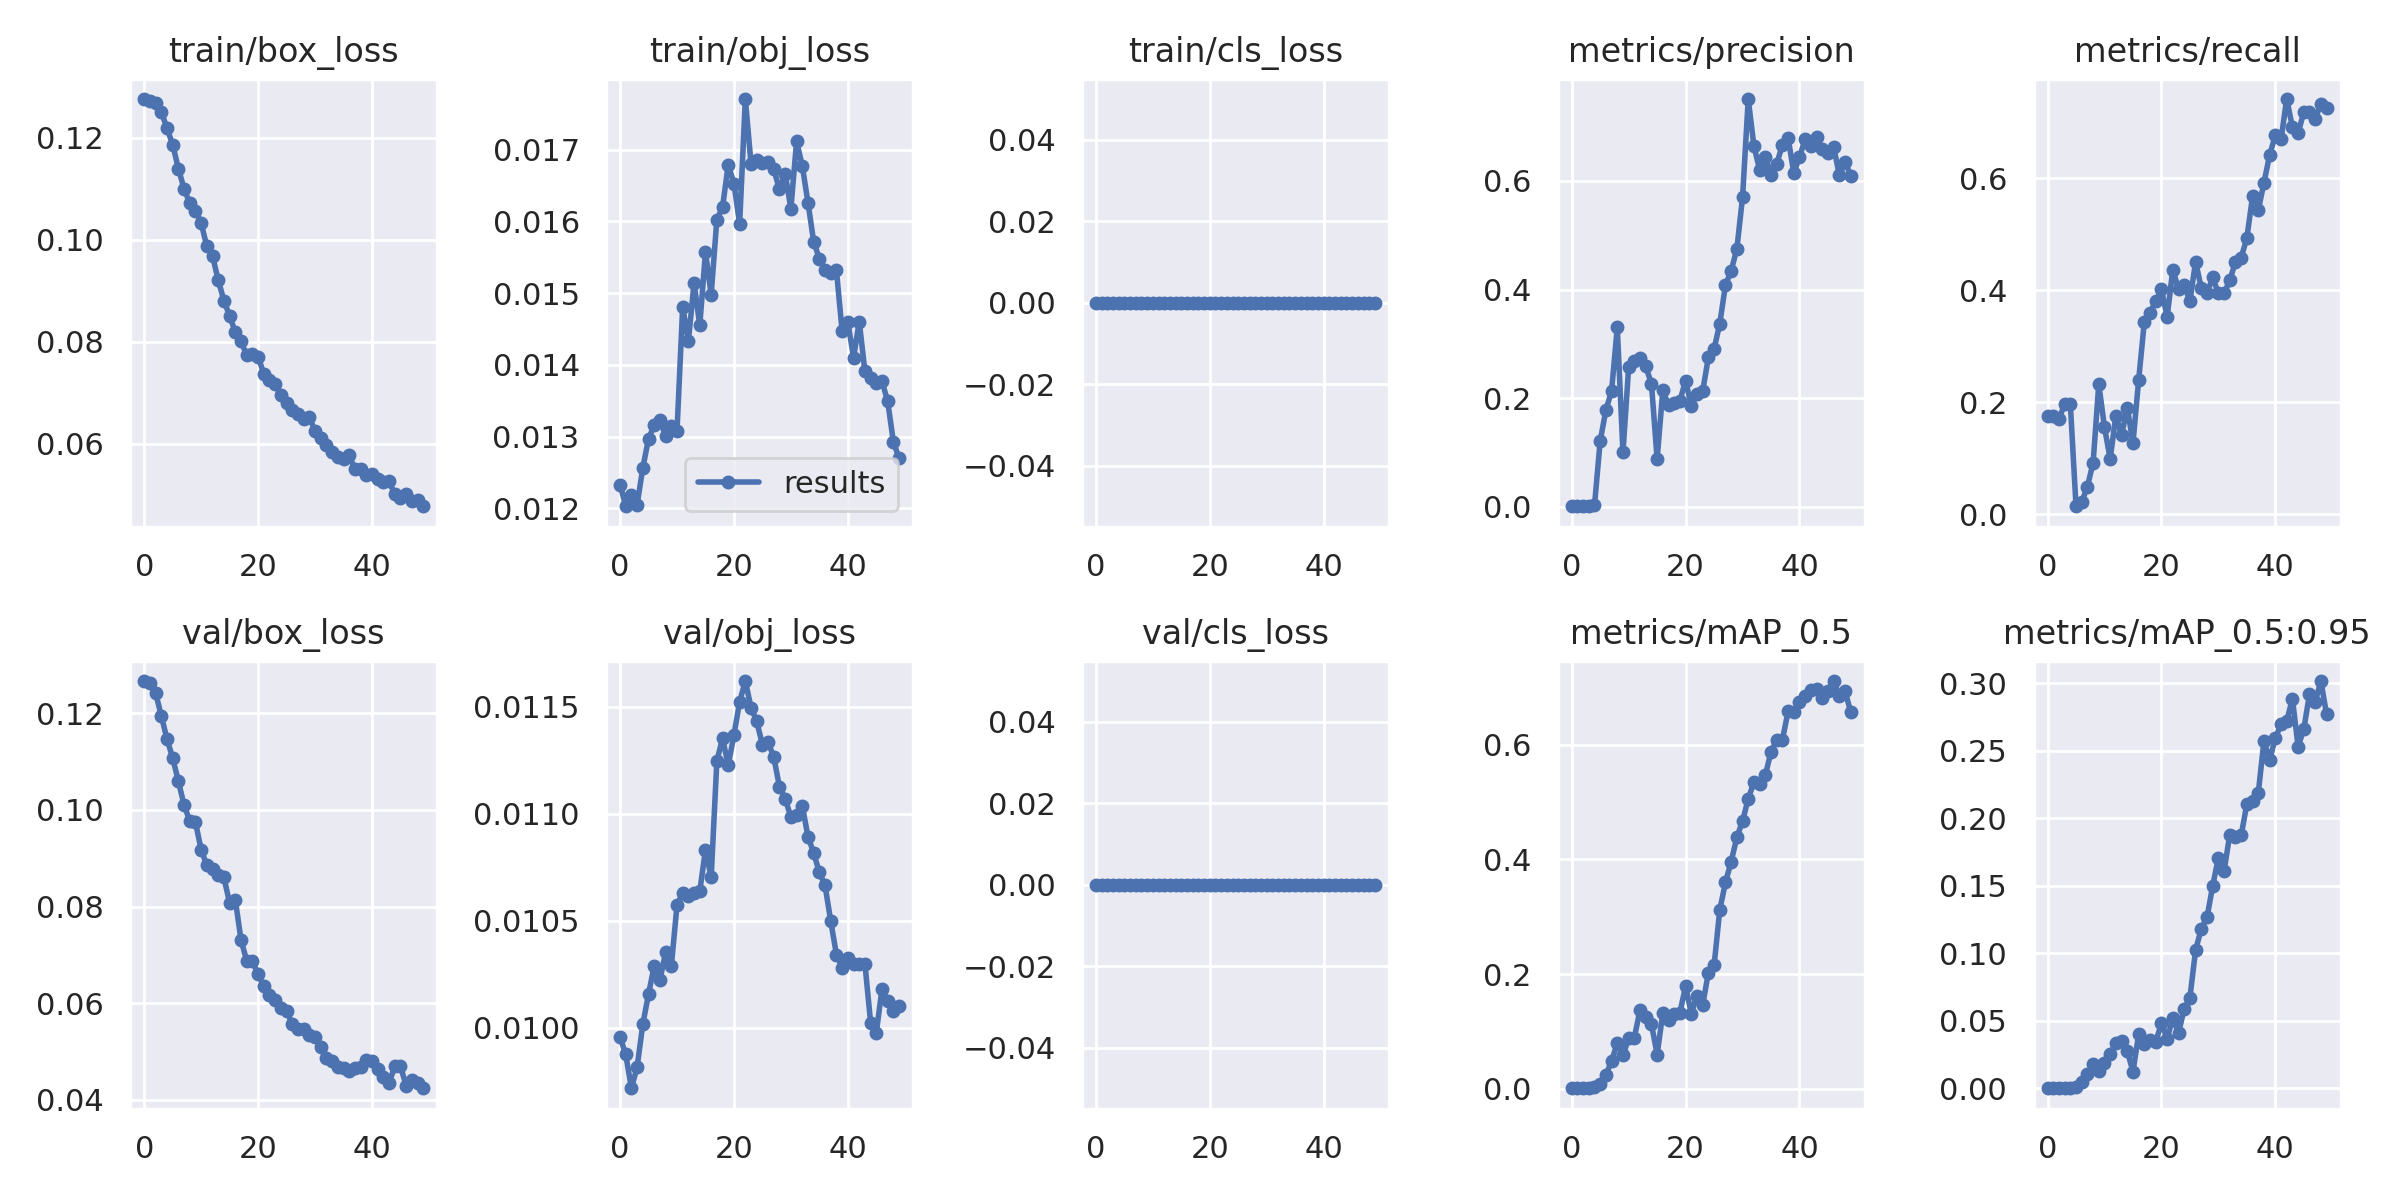

In [2]:
# Visualise the training Curves: 
from IPython.display import Image
Image(filename='/content/drive/MyDrive/yolov5/runs/train/running_model_baseline_Mars_05_IoU/results.png')

To validate all our models, we used the following basic command, and made sure to have the --task set to test. So that we could test our model on Unseen data: 

In [ ]:
!python val.py --weights /content/drive/MyDrive/yolov5/runs/train/running_model_baseline_Mars_05_IoU/weights/best.pt --data mars.yaml --img 416 --task test

We then trained our data using the 3 given pretrained model weights using simple transfer learning - without freezing any layers of the YoloV5 architecture and the following curve is the training curve for the large model that we found to perform the best: 

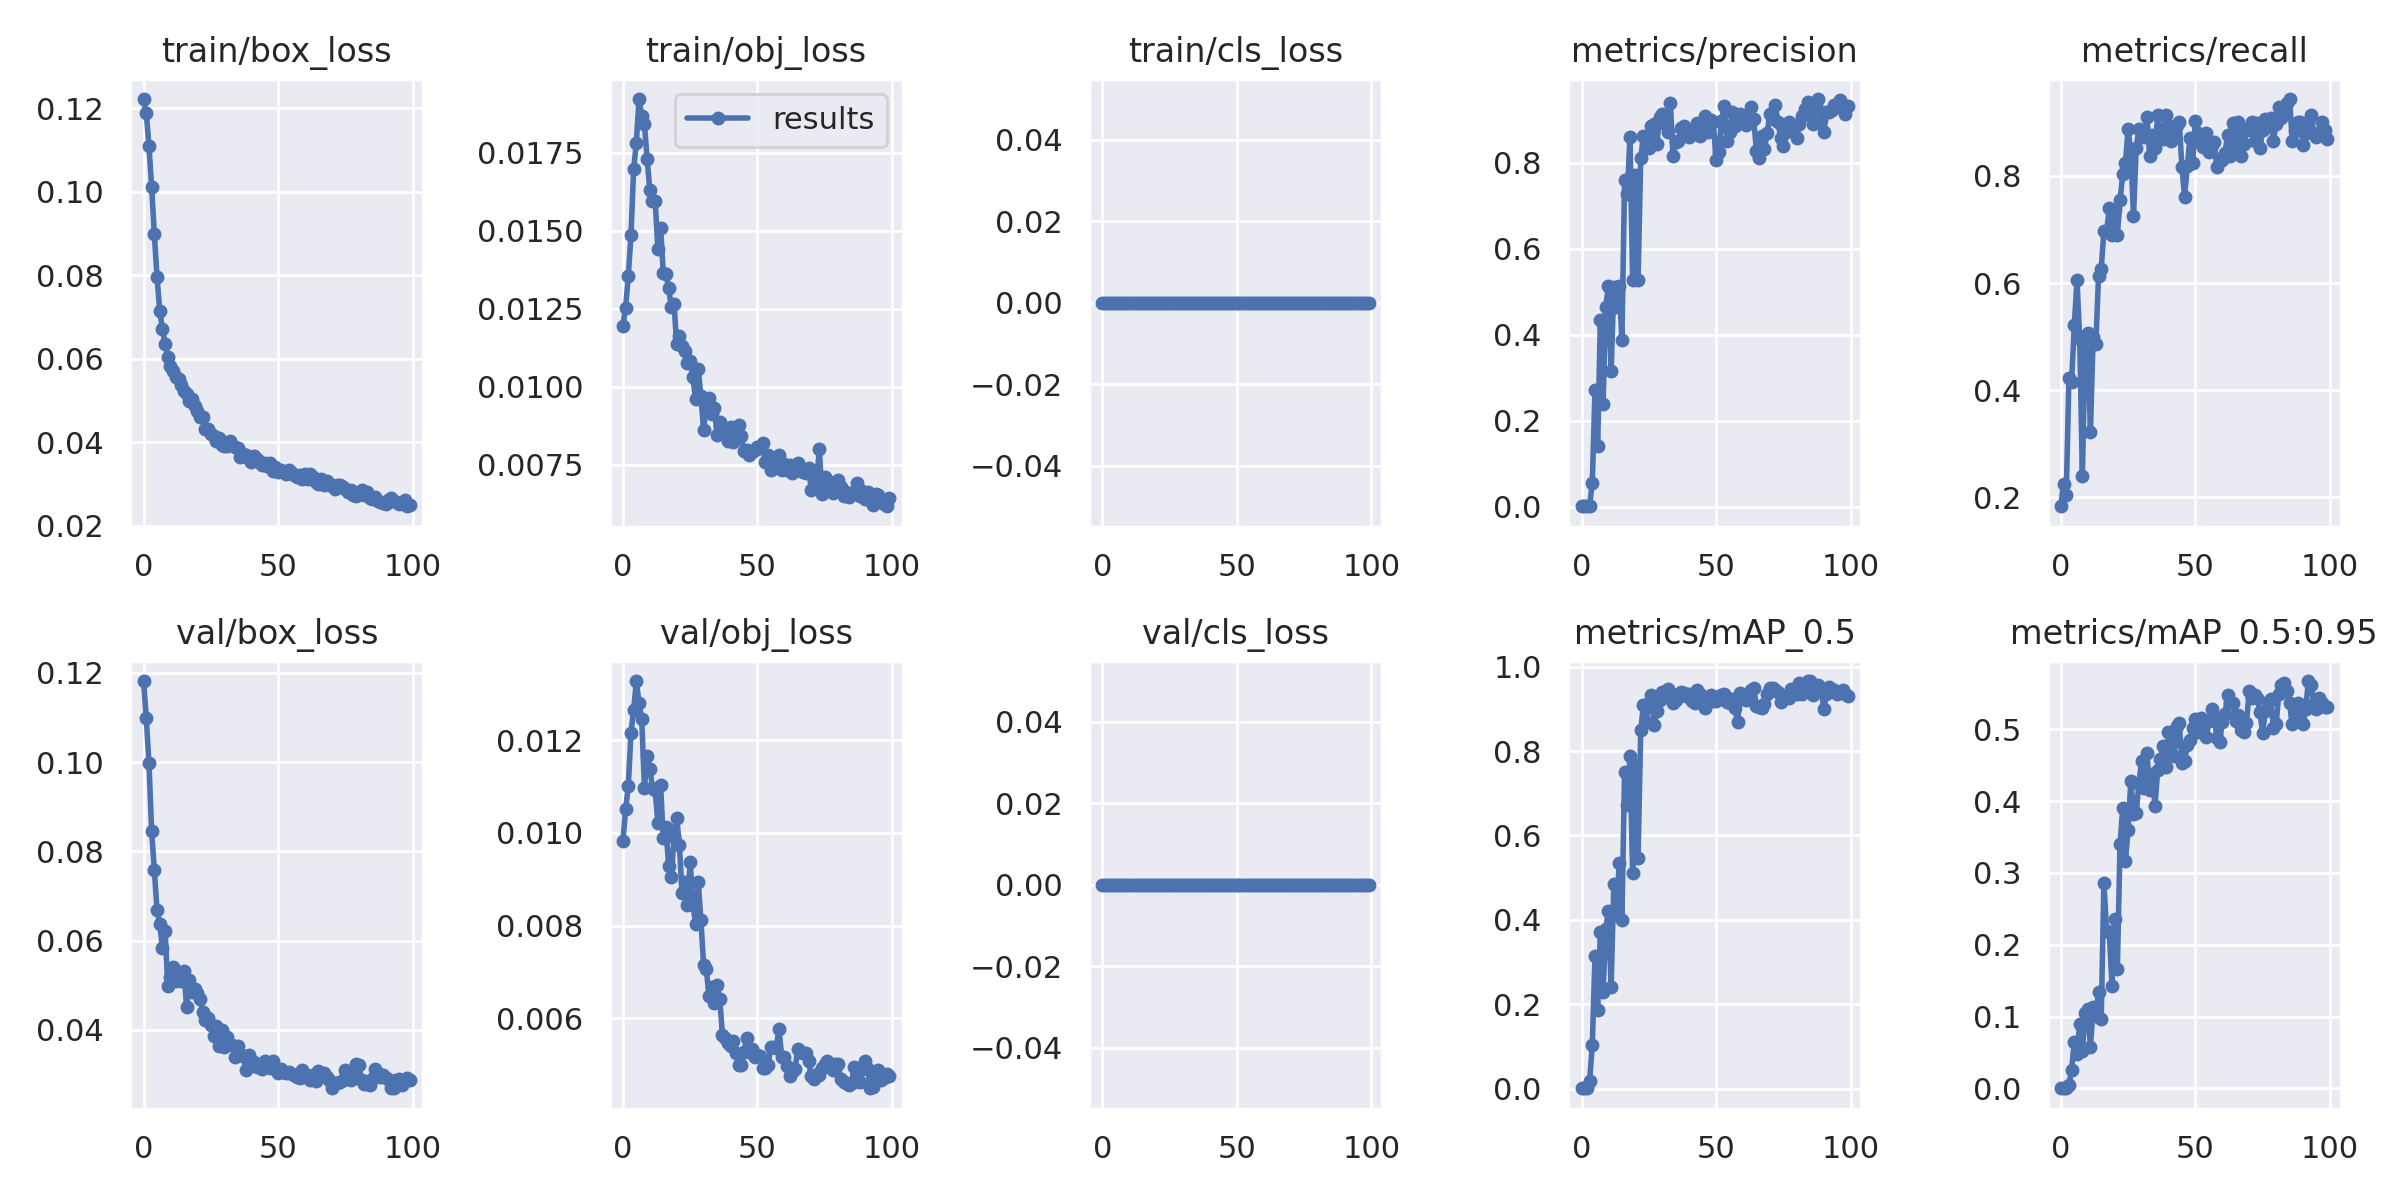

In [3]:
Image(filename='/content/drive/MyDrive/yolov5/runs/train/running_model_large_05_IoU/results.png')

We can make observations that the tran and validation losses for the box-loss and Object-loss are decreasing nicely and converging. We can also see that we are not yet overfitting with the boundary boxes. But I think that usnig further epochs could've led to some overfitting. 

Eventhough the Object-loss shoots up quite rapidly at the beginning of training, it does come back down a little, as we think the model learns to understand that our data is full of small craters that were not present in the training dataset.

All the metrics seem to be stabilised, and the calc-loss stays at 0 as we only have 1 class present.

When evaluating our model with the test set, we can see a high precision of 88%, recall of 86% and mAP of 90% for the large model. We decided that this was the best model for the moon data for now, because when looking at the next F1 curve, it showed a good balance between recall and precision at a good threshold level too: 

- Meaning our model was able to find a good balance between false positives and true negatives.

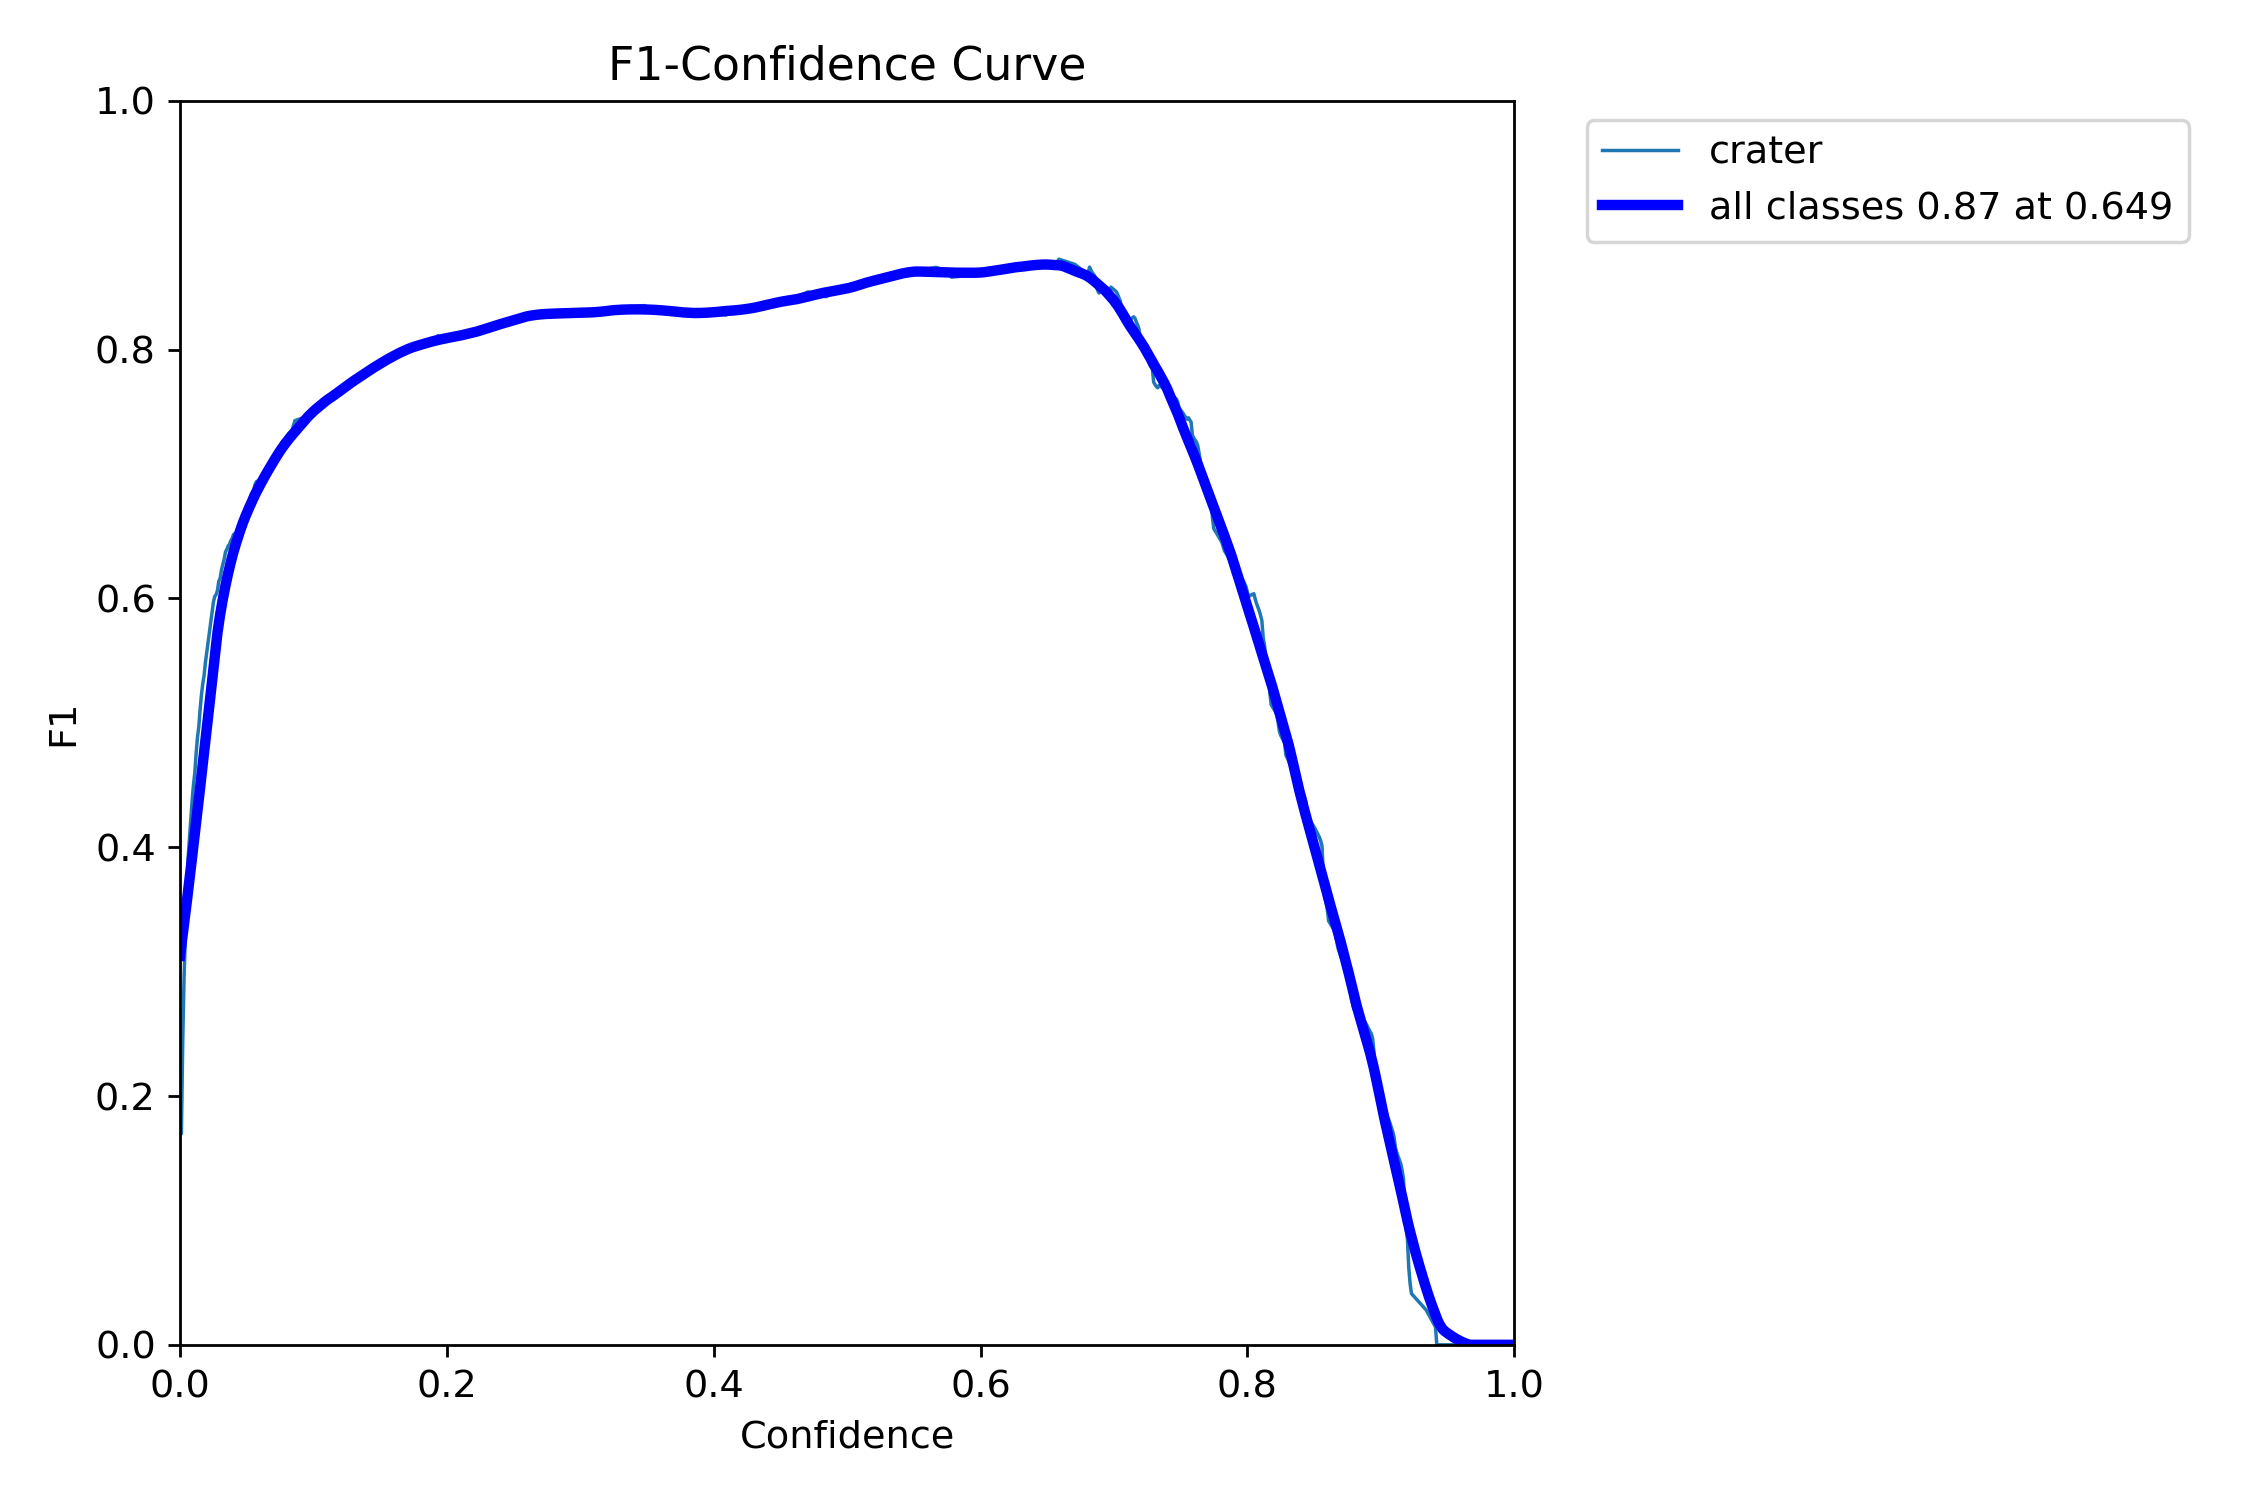

In [4]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/exp37/F1_curve.png')

As we did not have a functional Size frequency distribution plot, we also used common sense and analysed our validated data to see if we thought it accuretly predicted crater locations: 

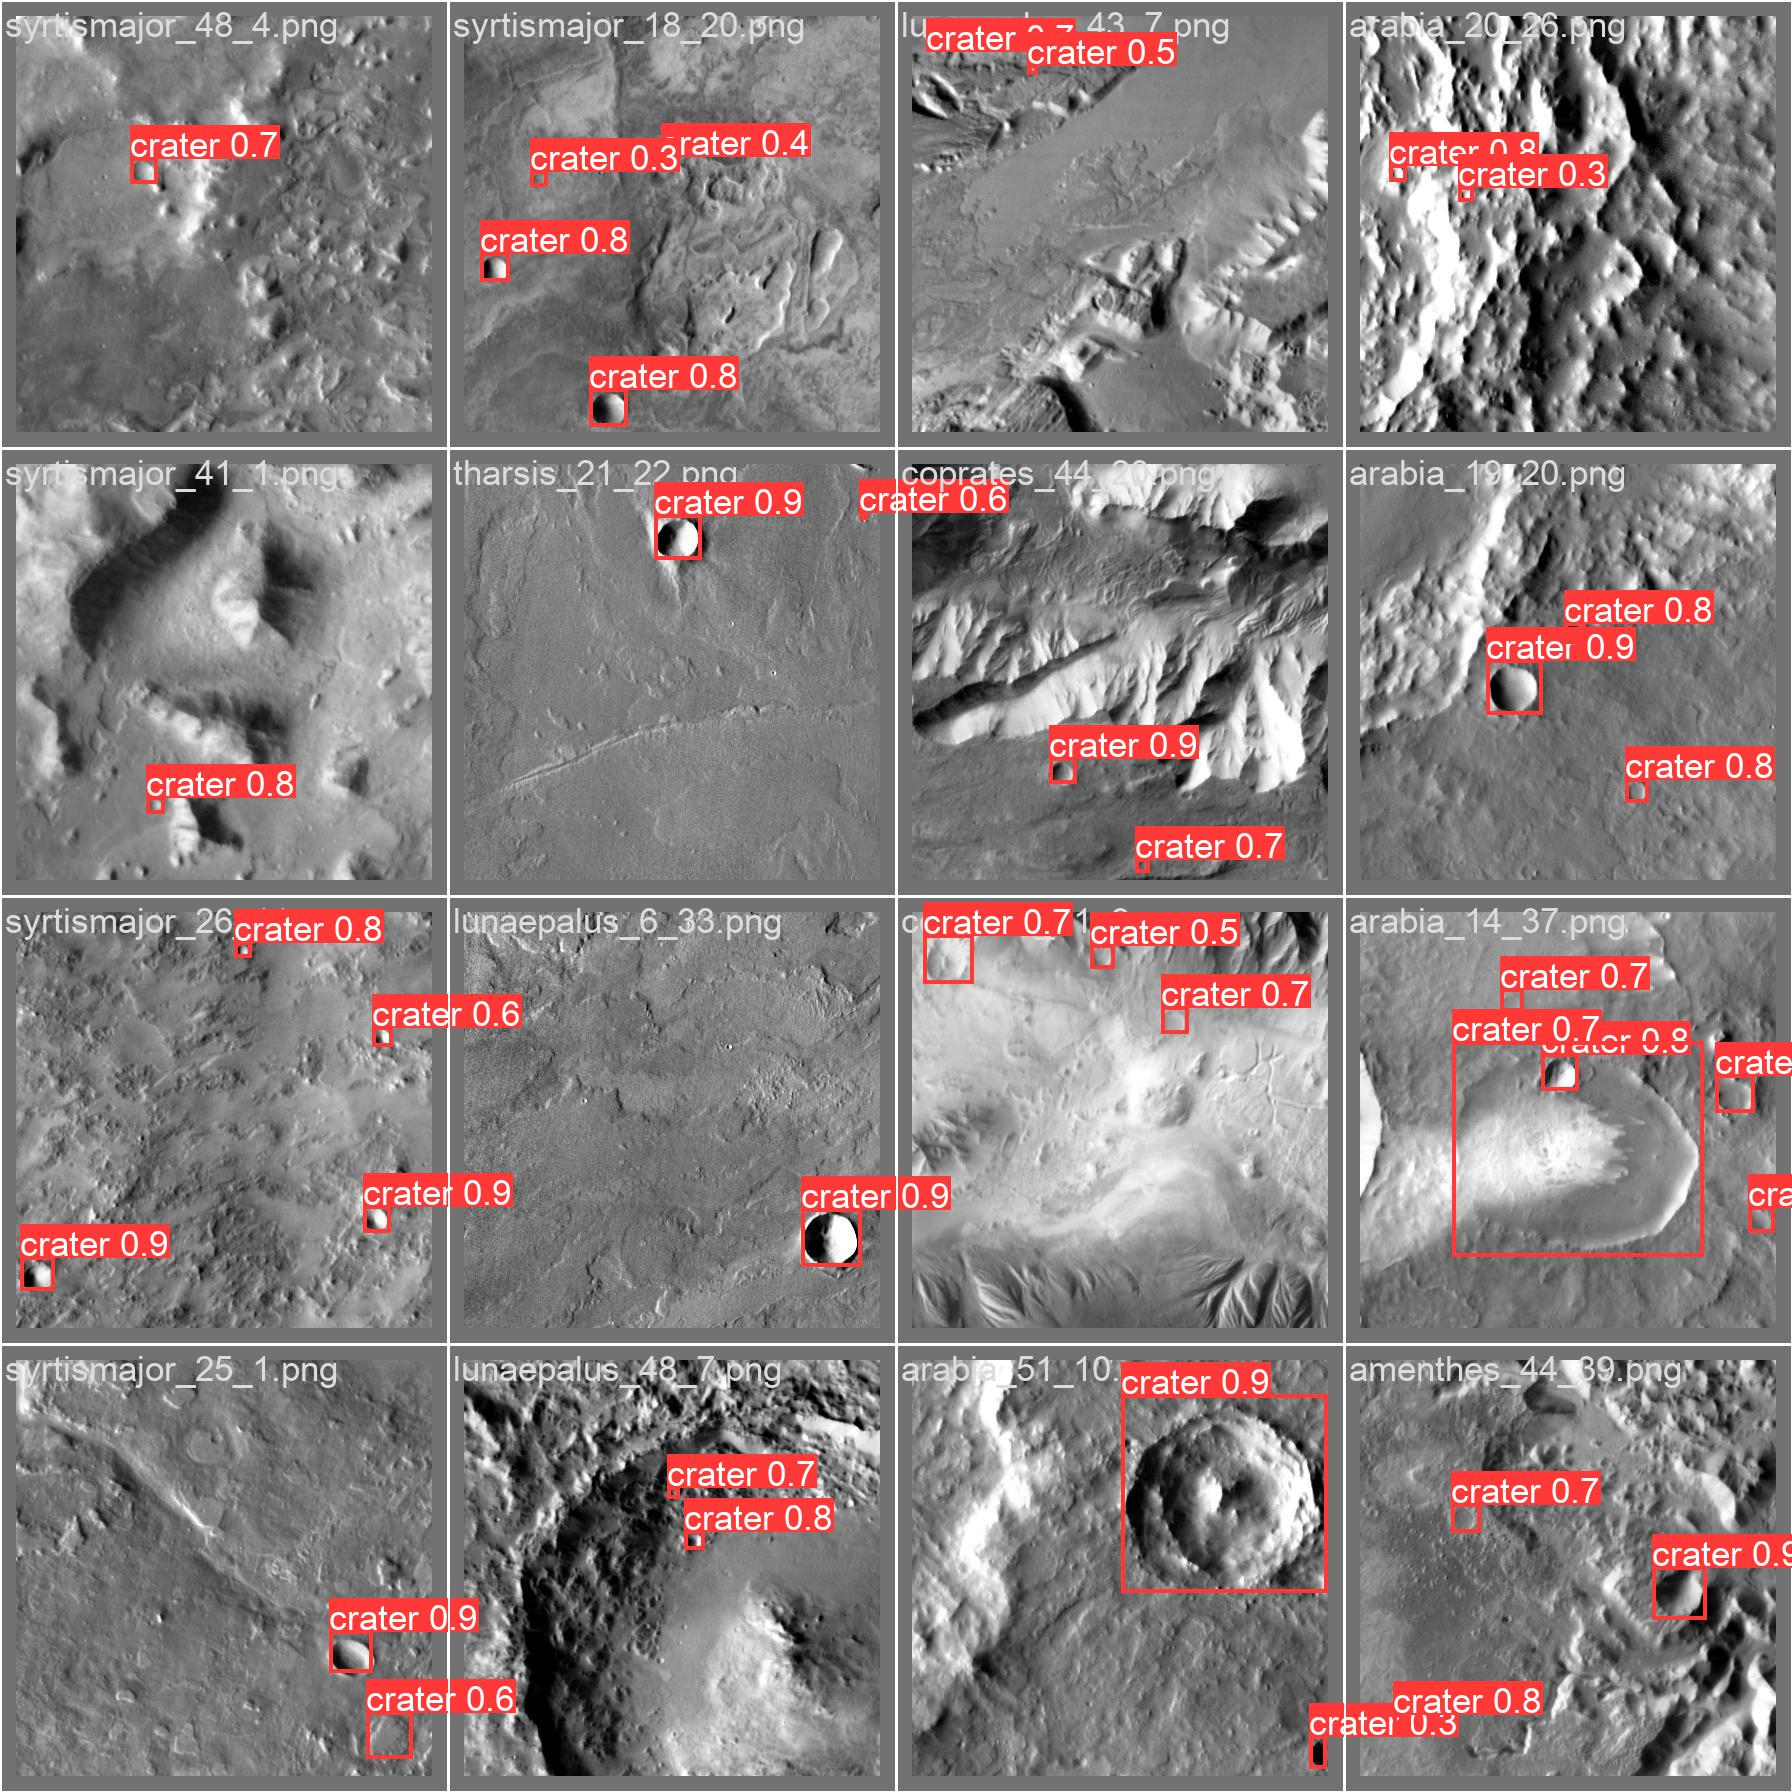

In [5]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/exp37/val_batch1_pred.jpg')

We can see that our large model was able to spot both large and small craters. Which is great.


### Transfer Learning: 

Instead of using the long and tedious evaluate function (which we tried with not great results) or manually testing hyperparameters, we decided on trying some different ideas to improve our model. We decided on this, as YoloV5 already implements great hyperparameters, and can also detect when to use different ones (such as autoanchor).

Instead we tried transfer learning: 
  - In this training example, we decided to freeze the backbone as the backbone is where most of the feature extraction is being done - adn as it was well trained and optimised using the coco dataset, we decided to put more focus on training the Neck layers and the output layers, which are the main layers for assigning if a feature which is found in the backbone is a crater or not.
  - After first training our model with frozen backbone, we then trained the same model again, this time with no frozen layers, for less epochs.

For transfer learning we used the same train function but added -freeze on the first 12 layers (backbone).

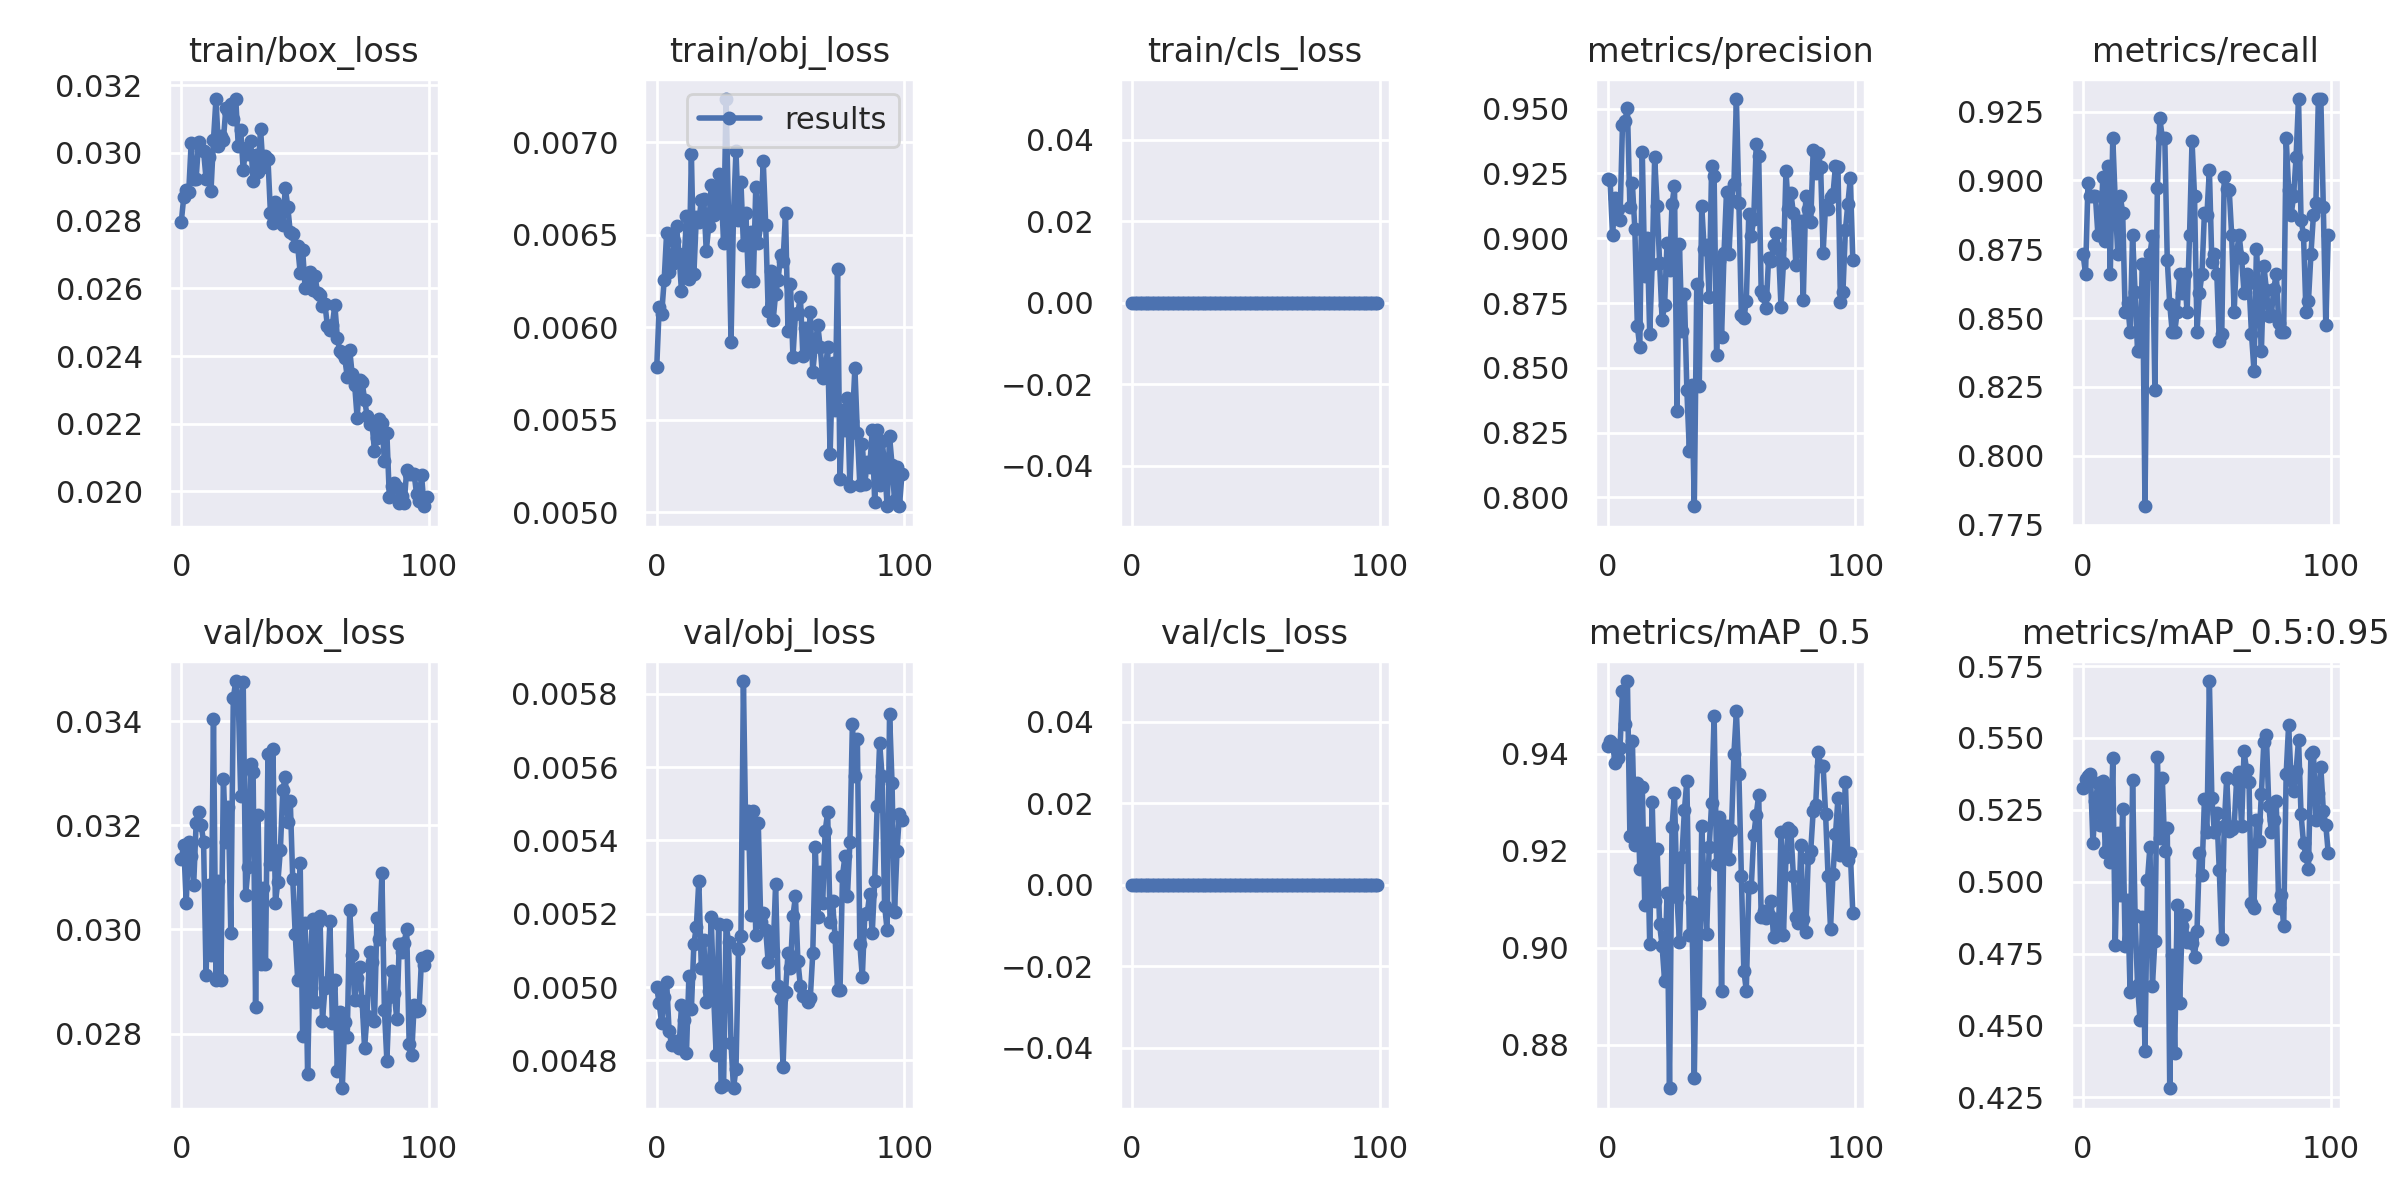

In [6]:
Image(filename='/content/drive/MyDrive/yolov5/runs/train/running_model_frozen_AFTER_backbone_05_IoU_large_Good/results.png')

We can observe some suprising results. The train box loss and object loss seem to be decreasing, but in a quite eratic way. The performance metrics stay quite stable along all the 100 epochs, which is quite surprising. However our learning rate is still quite small, so it is possible that freezing the backbone has led to optimal weights being found, and therfore our further training with no layers frozen has found a local minimum.


An example F1 curve can be seen next: and is quite high at 86% but at a lower confidence threshold than our simple large model: 

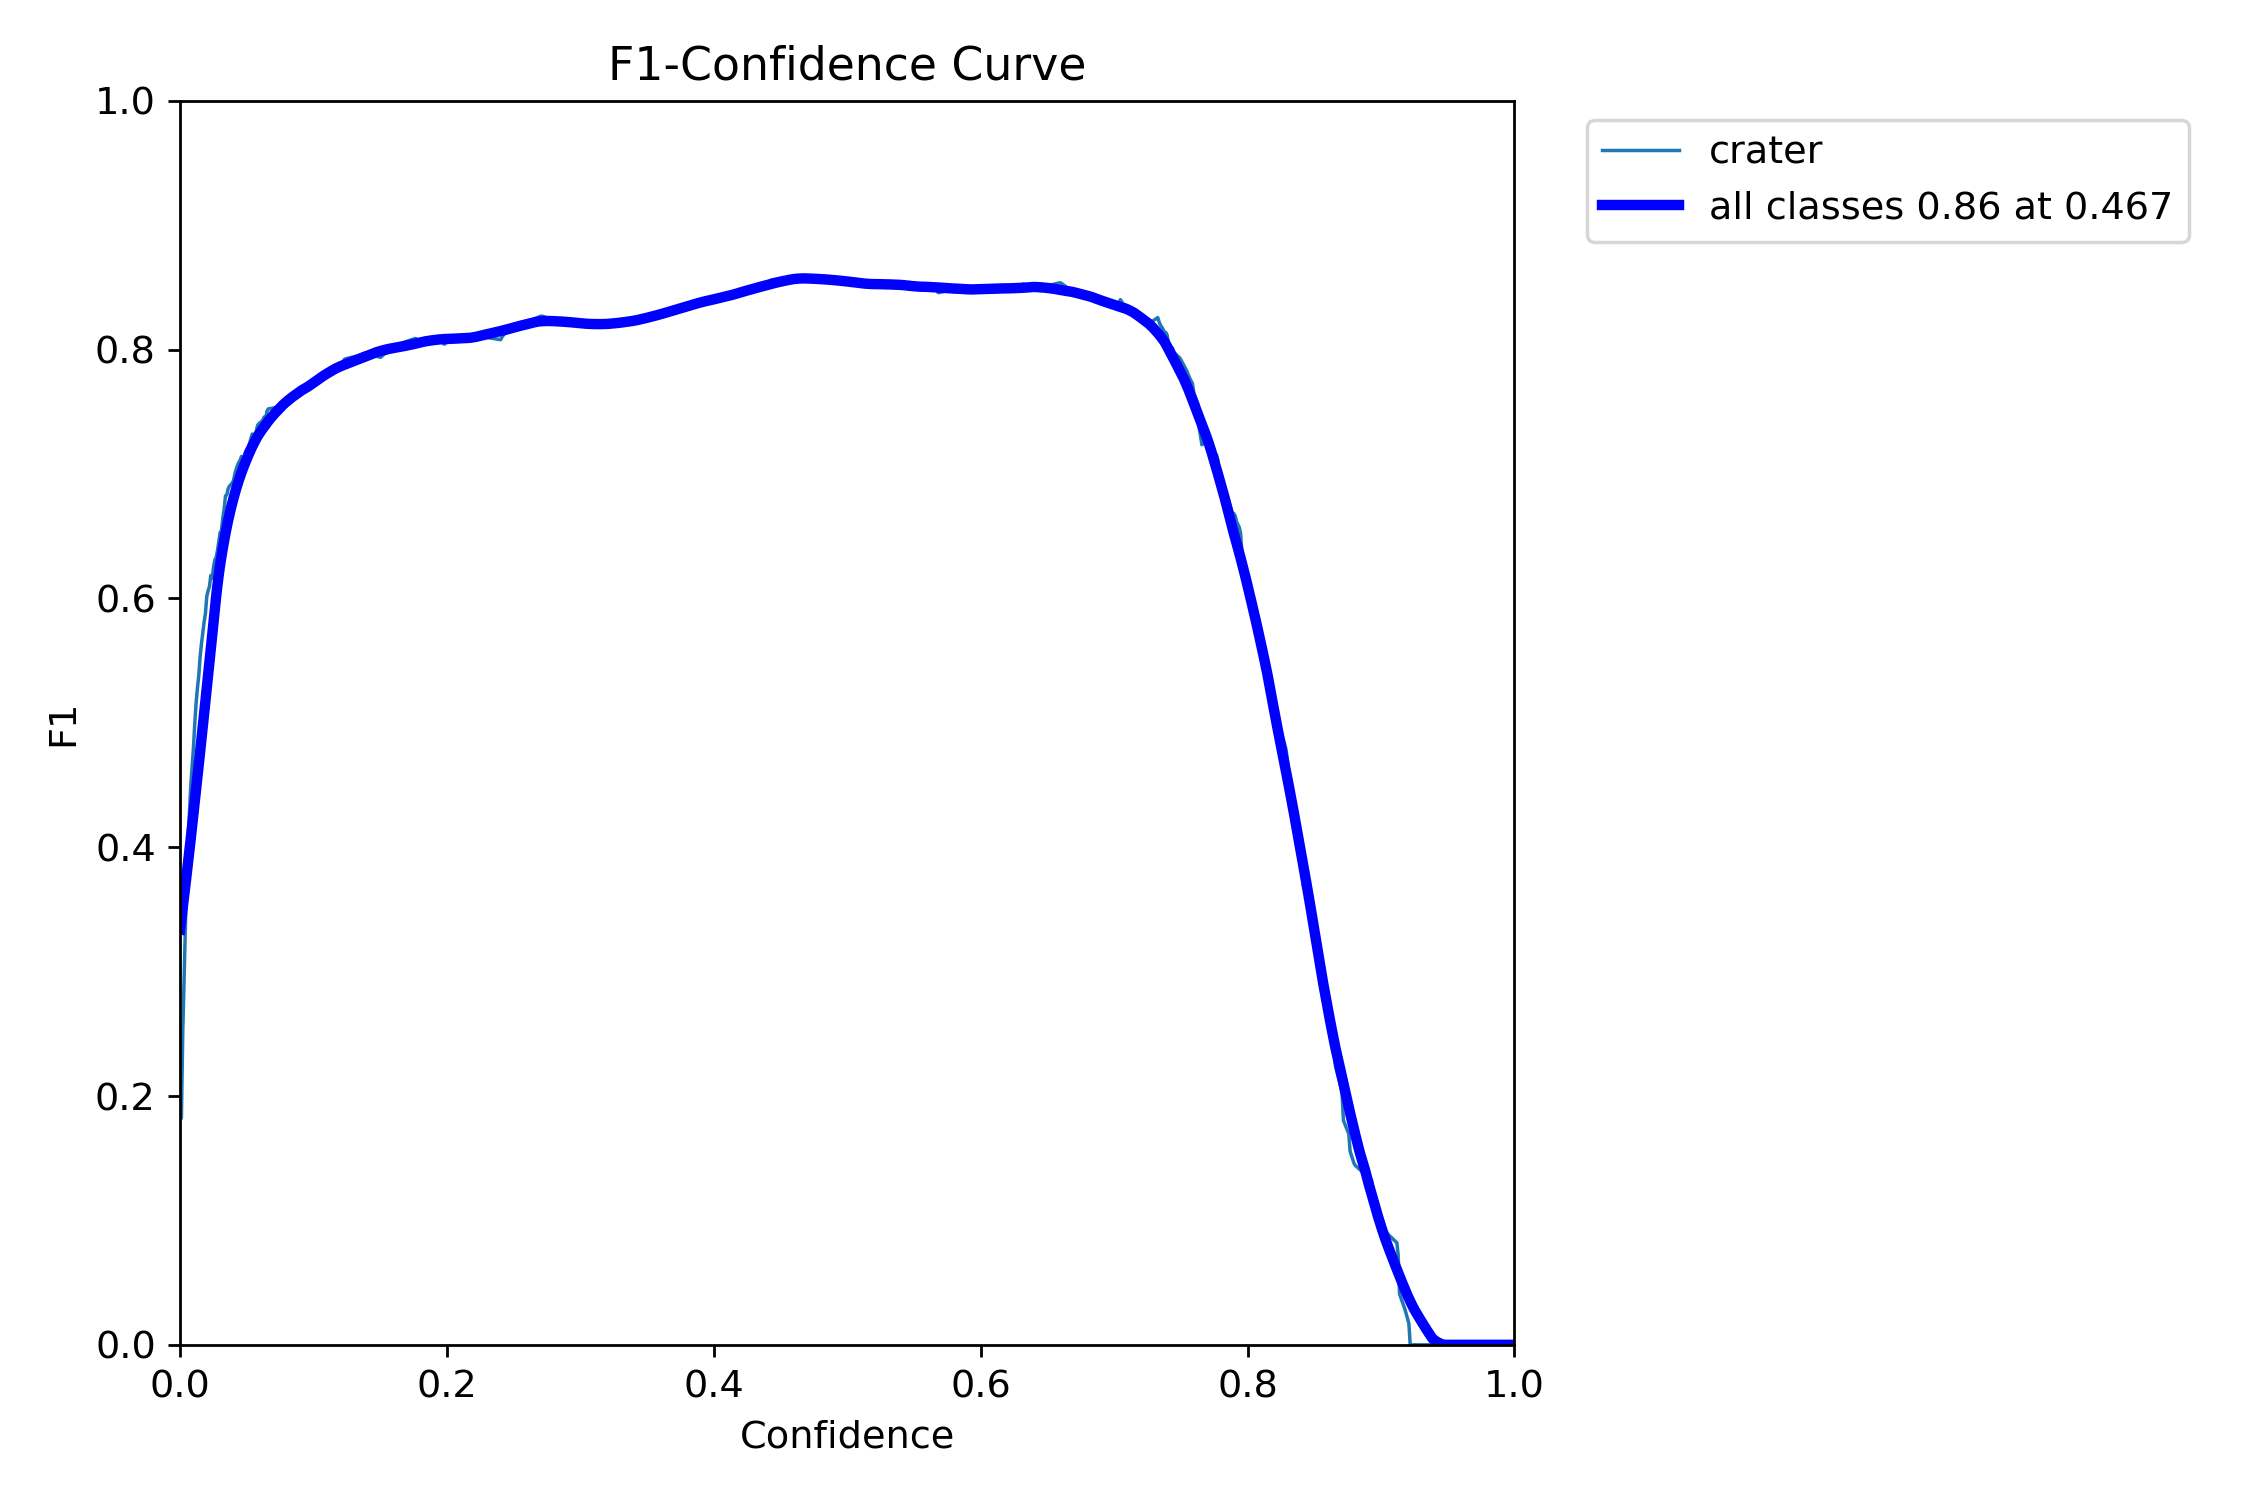

In [7]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/exp38/F1_curve.png')

We then went on to trying some ensemble methods, but this did not lead to significant results. If you would like to know more about how we ran all the above models, please see the Mars_implementation_Baseline_and_Tuning_Using_YoloV5 notebook given in the training notebook folder.

The following validation python line is run for ensemble validation: 

In [ ]:
!python val.py --weights /content/drive/MyDrive/yolov5/runs/train/running_model_medium_05_IoU/weights/best.pt /content/drive/MyDrive/yolov5/runs/train/running_model_AFTER_frozen_backbone_05_IoU/weights/best.pt  --data mars.yaml --img 416 --task test

### YoloV8: 
- We further tried using YoloV8 for training our model and the information for the training can be seen in the other notebook YoloV8 Implementation Mars. Where we were able to reach precisions of 93%, recall 92% and mAP50 of 95%. Great results but we are still trying to implement it in our GUI. So we will not be discussing it more in depth. However more information can be found in the yolov8_implementation_mars notebook. 

# Moon: 

The training for the moon was quite tricky, as we had issues with our own-generated data. Therefore we started off by training our data on the full dataset given to us by Gareth, while still preprocessing it and splitting it with the train/val/test split (0.8/0.1/0.1).

## Difference in between Mars/Moon Data: 

- Much larger dataset - In this case our train/val/test split makes more sense, as we have a 0.8/0.1/0.1 split.

- The data for mars was very similar, with no parts much darker than the other.

- Another difference between the 2 is that there are no sedimentary rocks or lava flows and big differences in surface areas on the moon.

This is one of the main reasons why we decieded to train 2 different models for mars and the moon. 

## Main hyperparameter difference: 
- As we had much more data for the moon, we could not just use all the images in each batch, as this would lead to memory issues, therefore we chose a random batchsize of 128. 
- We chose an epoch number of 50 as it seemed to work okay for convergence and allowed for faster traning times.
- Still the same IoU threshold of 0.50. 

## Simple Data augmentation: 

We also tried some little data-agumentation by reducing the image size on Gareth's data. Instead of the original 640x640, we ran it with -img 416

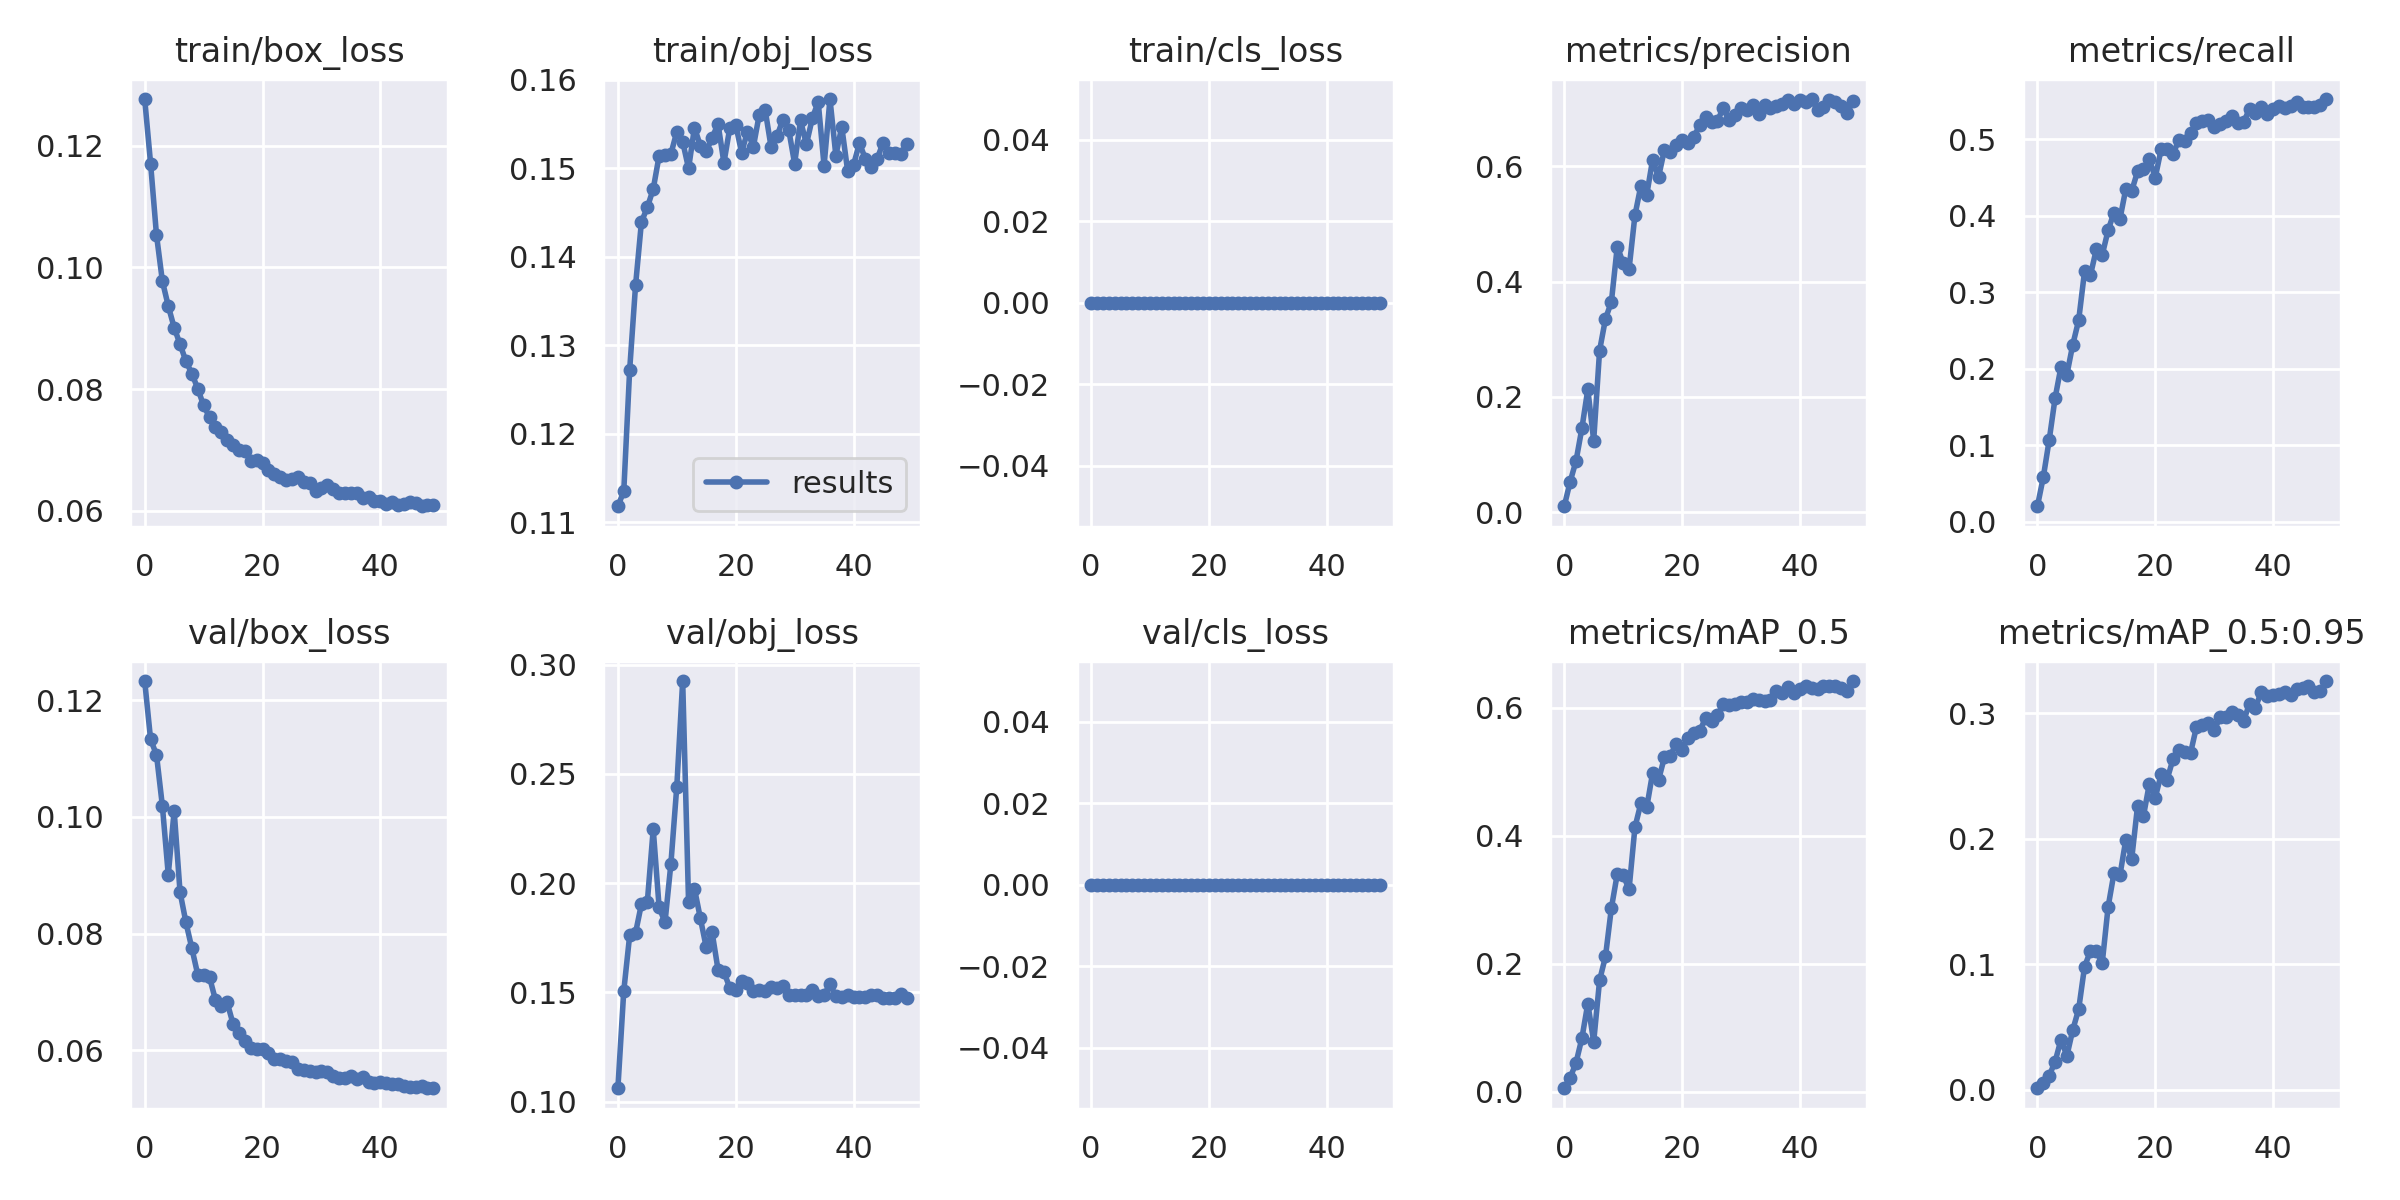

In [8]:
Image(filename='/content/drive/MyDrive/yolov5/runs/train/running_lunar_model_baseline_small_IoU502/results.png')

We can see that the box loss for the train and val are converging nicely, however the objext loss is still behaving eratically. I am not sure why, but I suppose it is because there are so many false positive (craters that are model detected but are not in the training data) due to imbalanced dataset (loads more small craters than large ones). We will be ignoring this for now, eventhough we should have looked into this more. It is present in all of our Moon training. 

Plotting the F1 curve for our model trained on all of Gareth's dataset, we can see that our results are quite average: 

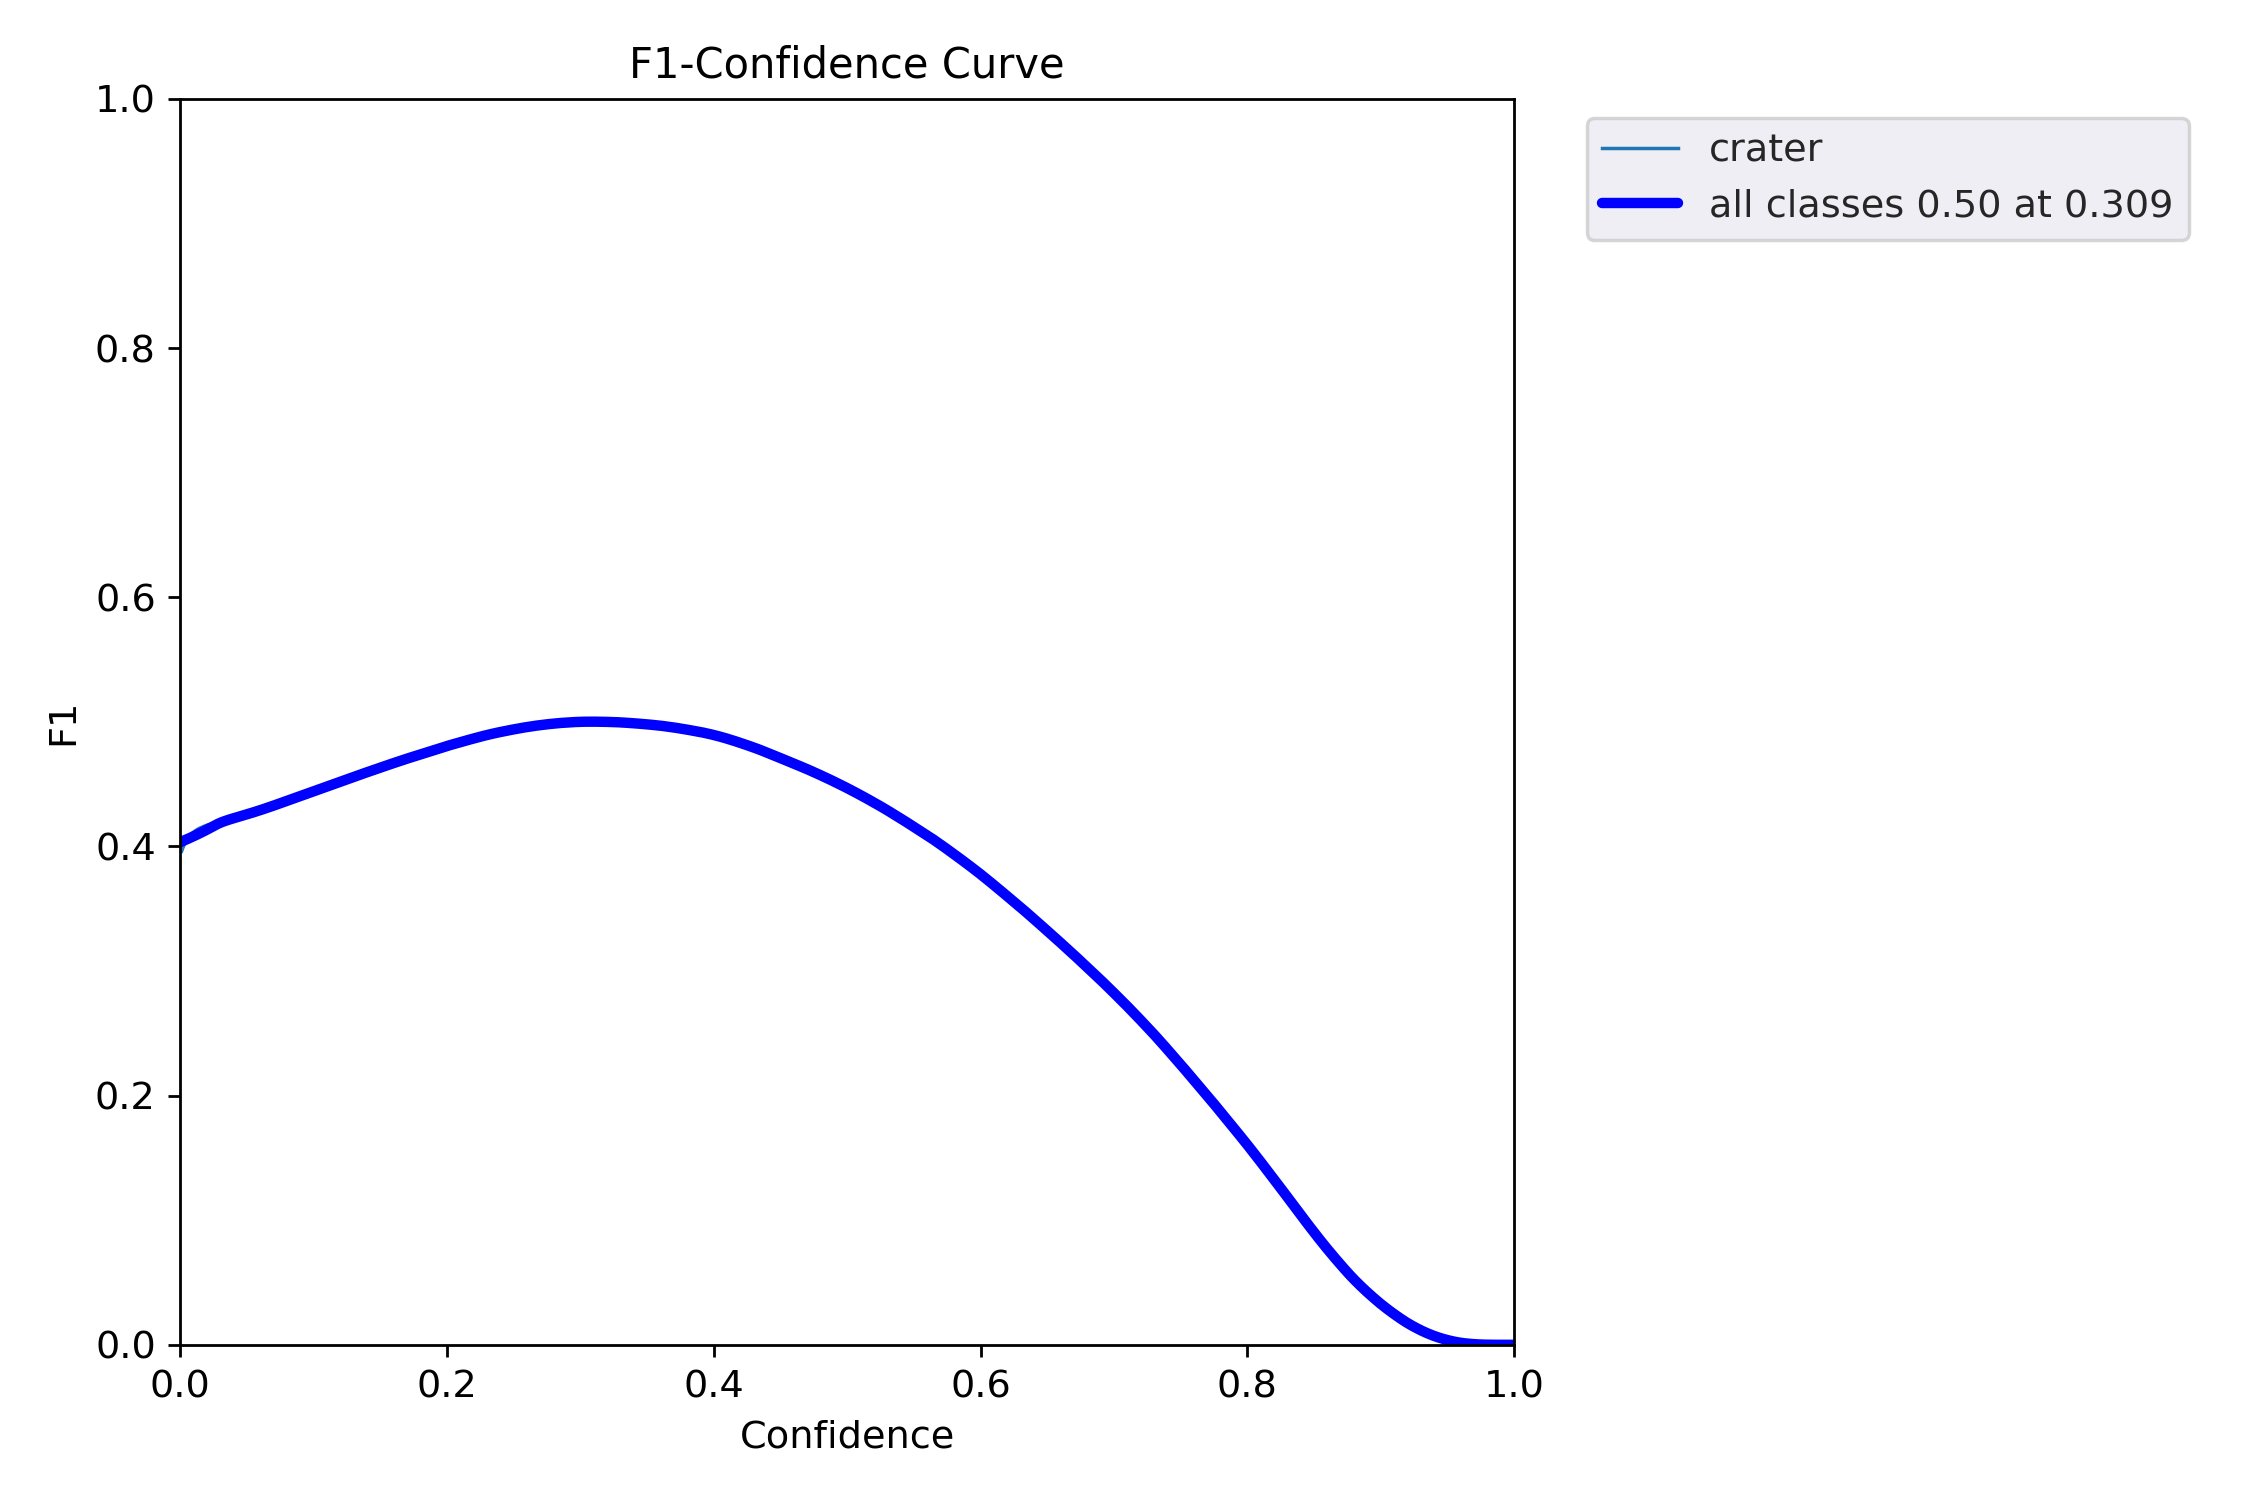

In [9]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/Lunar_validation_small_model_gareth_data_05_IoU/F1_curve.png')

We had simple a simple baseline with precision 67%, 40% recall and 50% mAP50 when using smaler sized images compared to the next with the normally sized images: 


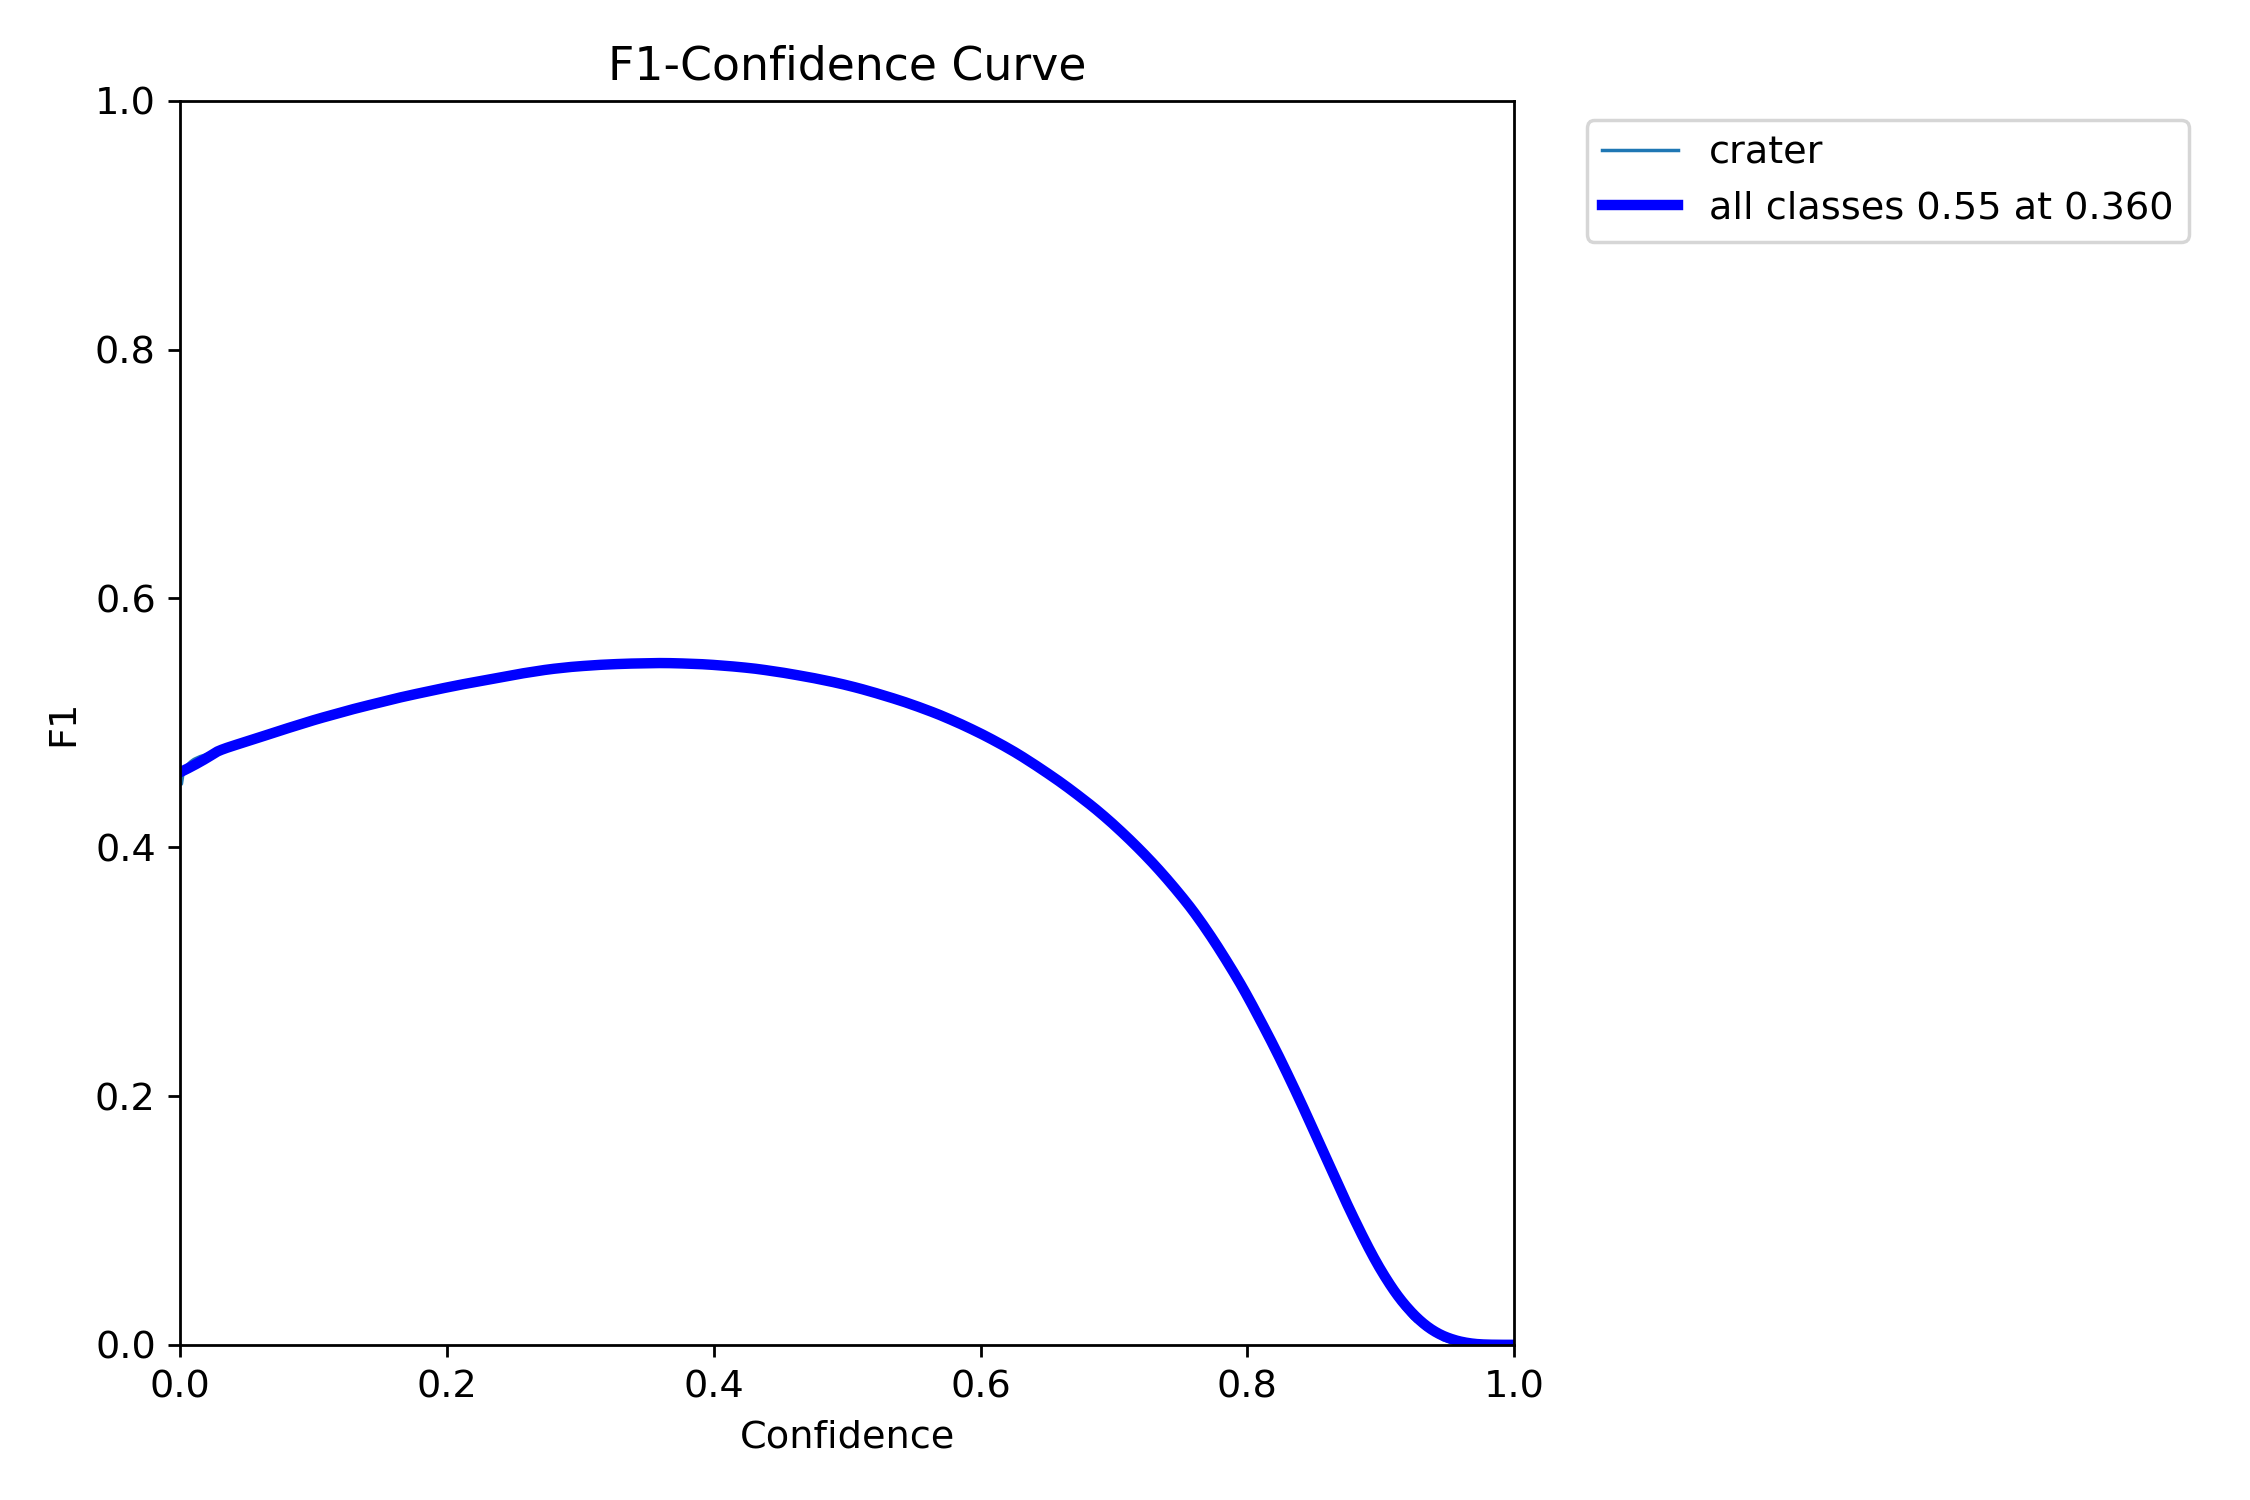

In [10]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/Lunar_validation_Medium_model_gareth_data_05_IoU/F1_curve.png')

From the F1 curve, we can see that our model is working a little better, as our threshold has increased to 36%. However the maximum value is still quite low. This is because our precision and recall are both still quite average at 73% and 44% and our mAP50 is at around 55%. This suggests that our model is very average as mAP50 is close to 0.5. We do not have a good balance between precision and reacall, making our F1 curve look quite distorted too.

We trained the right sized images with a medium sized model which was pretrained, it showed better results than the small model, but this could either be due to the model size, or the image size.

We should have done more analysis on this. But for now, the medium model is better for Gareth's dataset

## Our Own Dataset: 

When we were able to get our own lunar training data ready, we ran out of time to download all the data and place into one single folder to just train one model on all the data.

Instead we decided to split the training data into 2 sides. The left (A, B) and the right (C, D) training data. We decided on this split as we noticed that the images on the right side were much darker than on the left.

This led me to beleiving that that possibly making an ensemble model where one model was trained on the left side and another on the right could lead to increased variance in our results. Meaning our ensemble model could detect craters in both dark areas and light ones.

As we do not know what the test data will look like on Friday, I thought Our model could perform well like this.

Therefore the steps were the following:

- Preprocess the data:
- Split the left side (A, B) into train/val/test split
- Train a medium model on it (Faster than the large but still close in metrics)
- Validate on data from the left side, as well as data on the right side (as we have spatial data and it is good to test our model on data that is not its location of training).


We used the medium pretrained models, as those showed the best results when using Gareth's dataset. 

The following are the 2 training and validation curves and metrics for the model trained on the left side and the right side: 

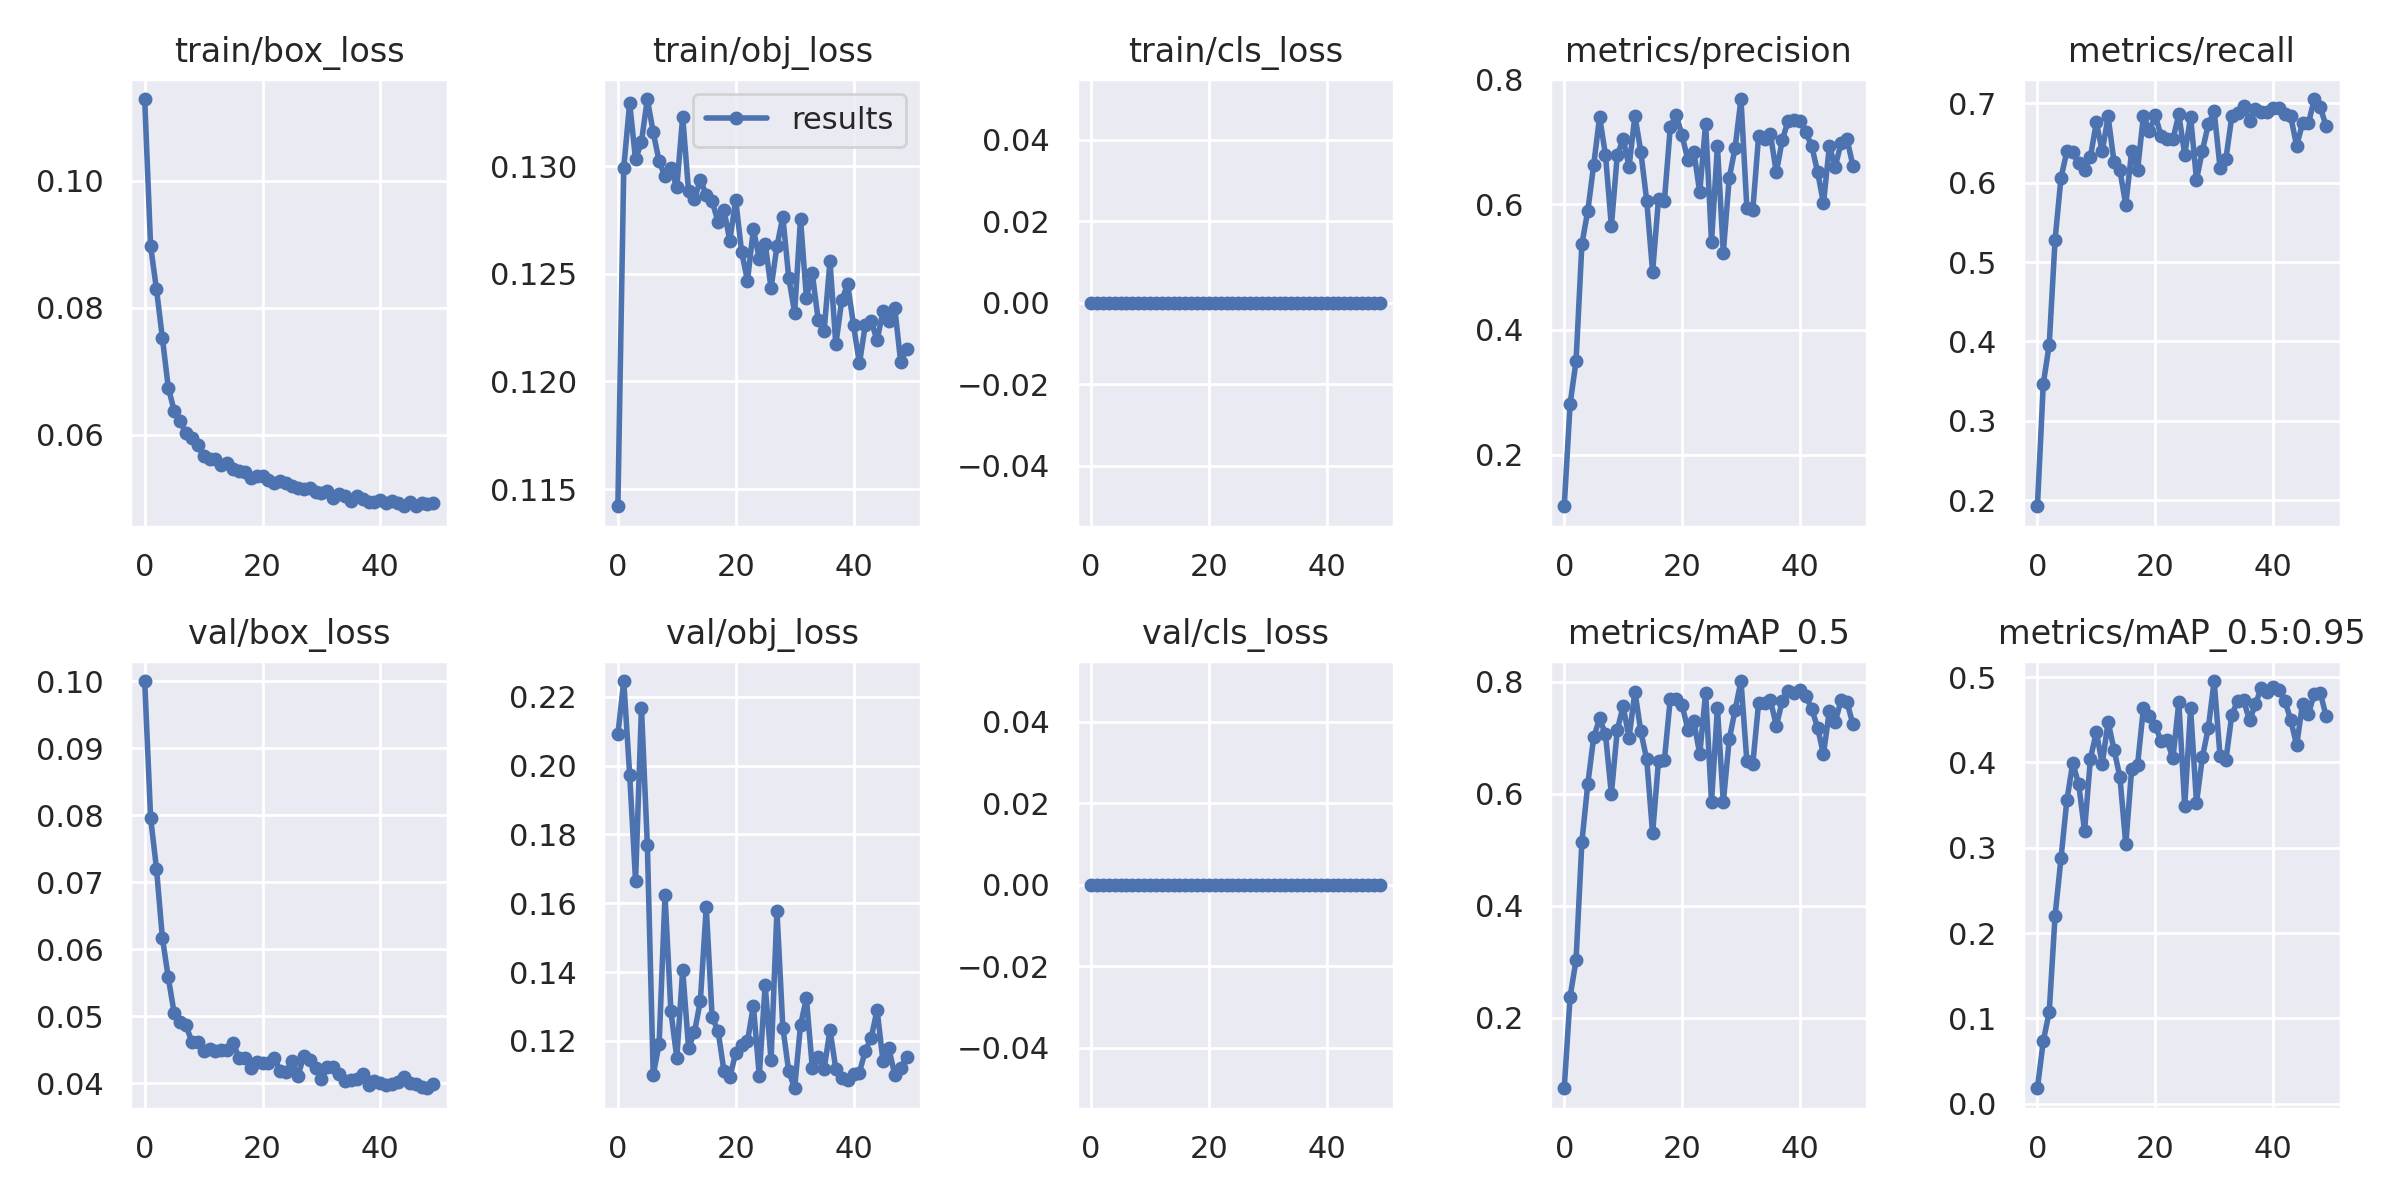

In [11]:
# Left side: 
Image(filename='/content/drive/MyDrive/yolov5/runs/train/Lunar_Model_our_data_Left_side/results.png')

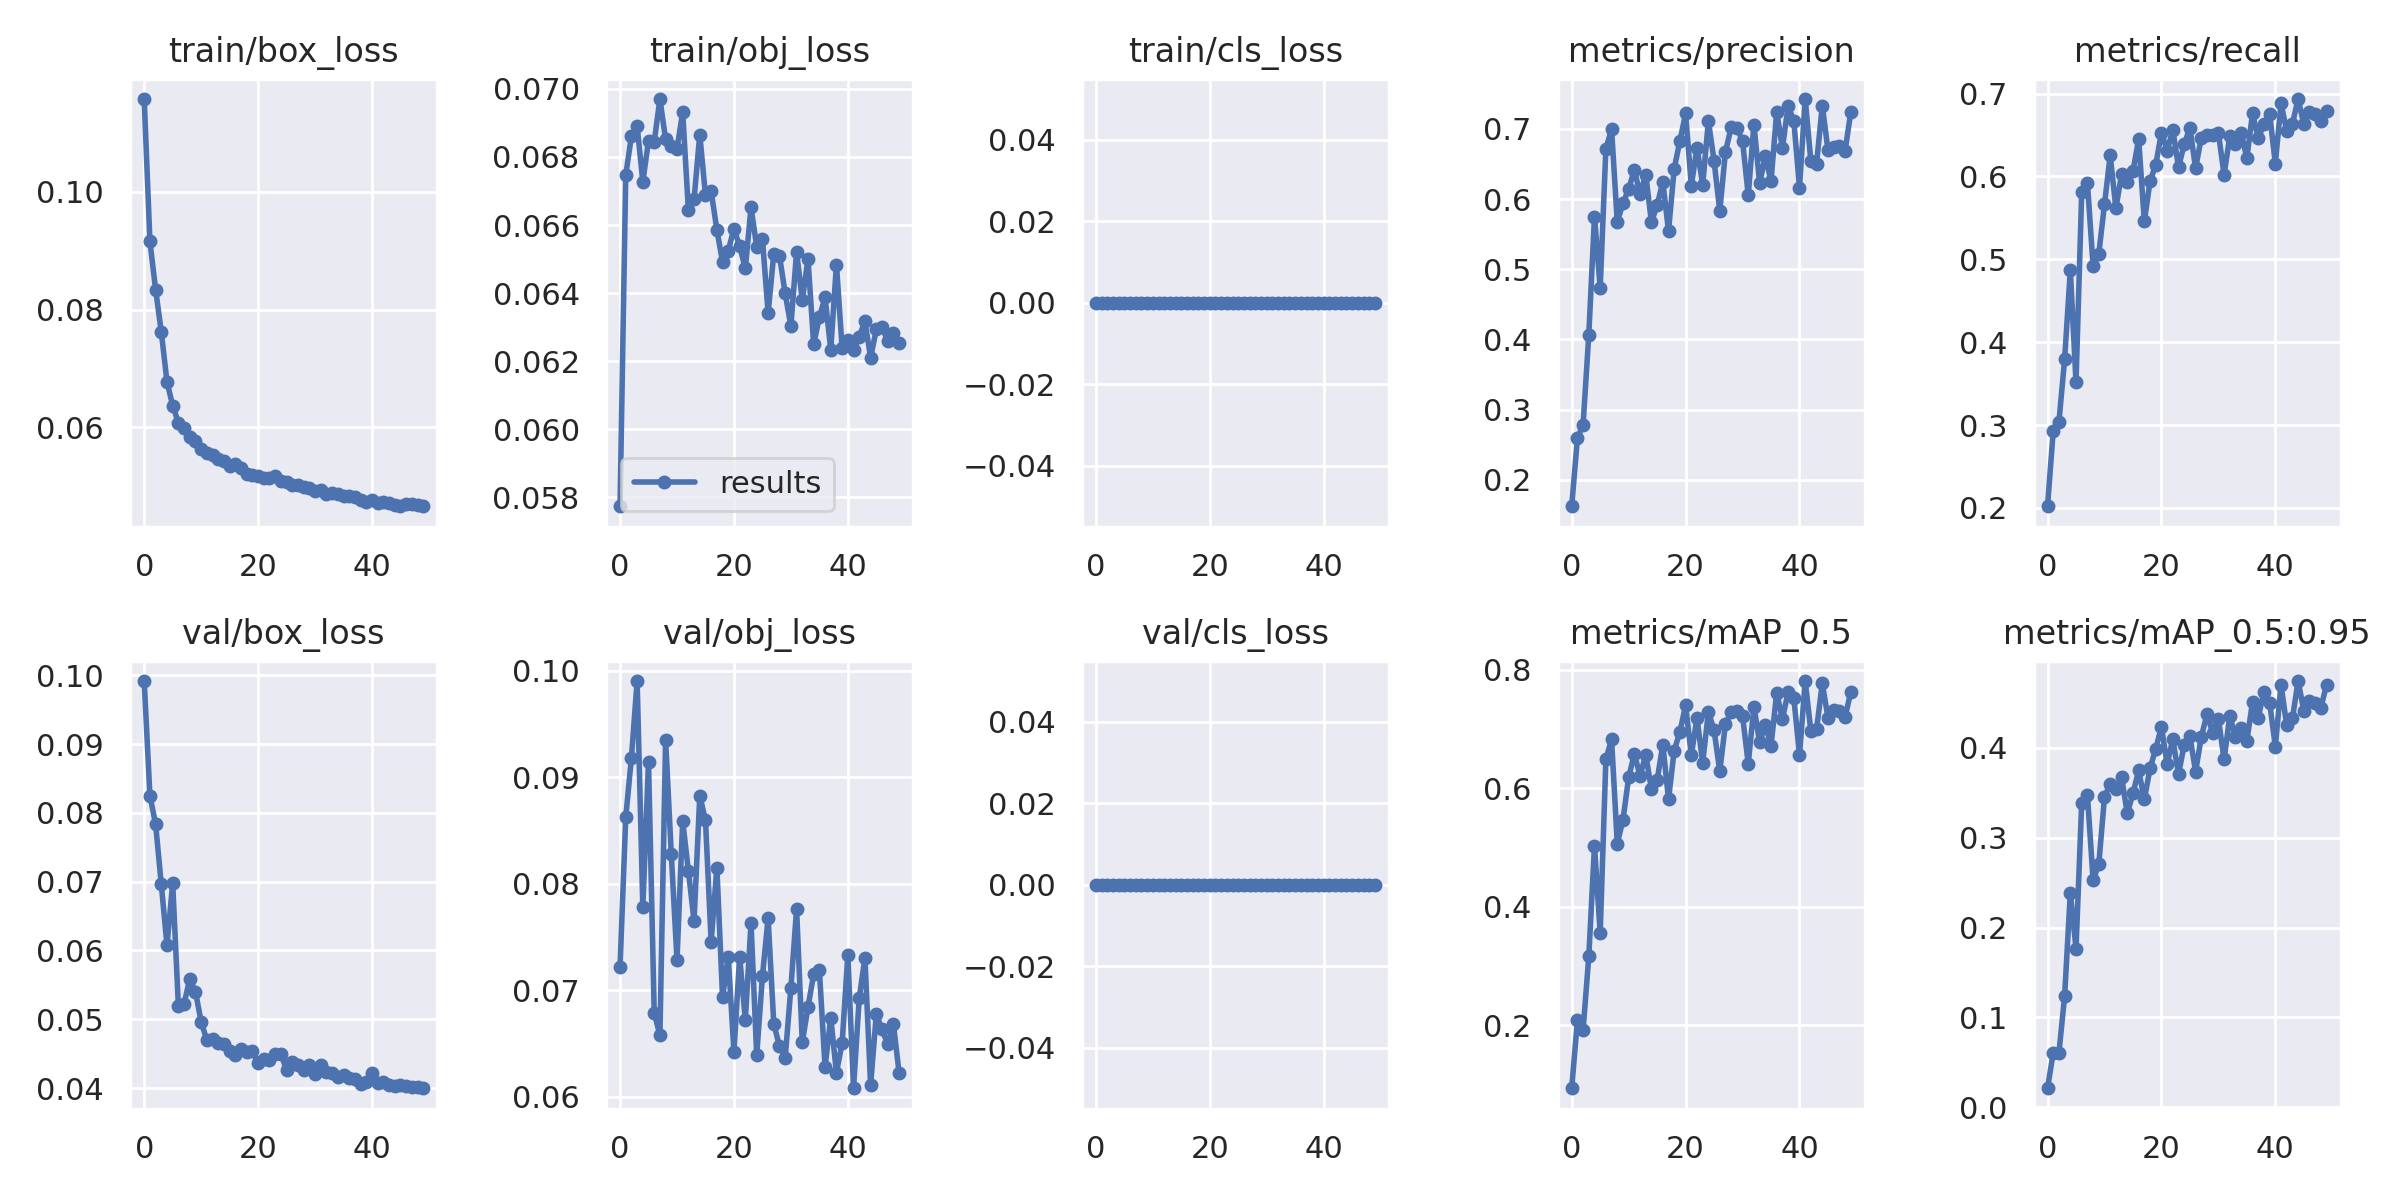

In [12]:
# Right side: 
Image(filename='/content/drive/MyDrive/yolov5/runs/train/Lunar_Model_our_data_Right_side/results.png')

Further testing our results on the same side as the model was trained on led to better results than on the other side of the data. This makes sense, as the models were not trained on the lighter or darker parts of the data. 

If you would like to see accurate results and F1 curves for these models on the different sides of the data please take care in looking in the Moon_implementation_on_gareth__and_our_own_data Notebook, as there is way too many validation lines - making it quite hard to read.

However, when using an ensemble of both methods (left and right) on the test data on the right (darker) and left (lighter) side, we were able to reach optimal metric scores and great F1 scores with higher thresholds than using the models alone. This is because ensembling can help to improve the performance of spatial data models to produce a more robust and accurate predictions.

As can be seen on the following F1 plots on the right side and the left side test data: 

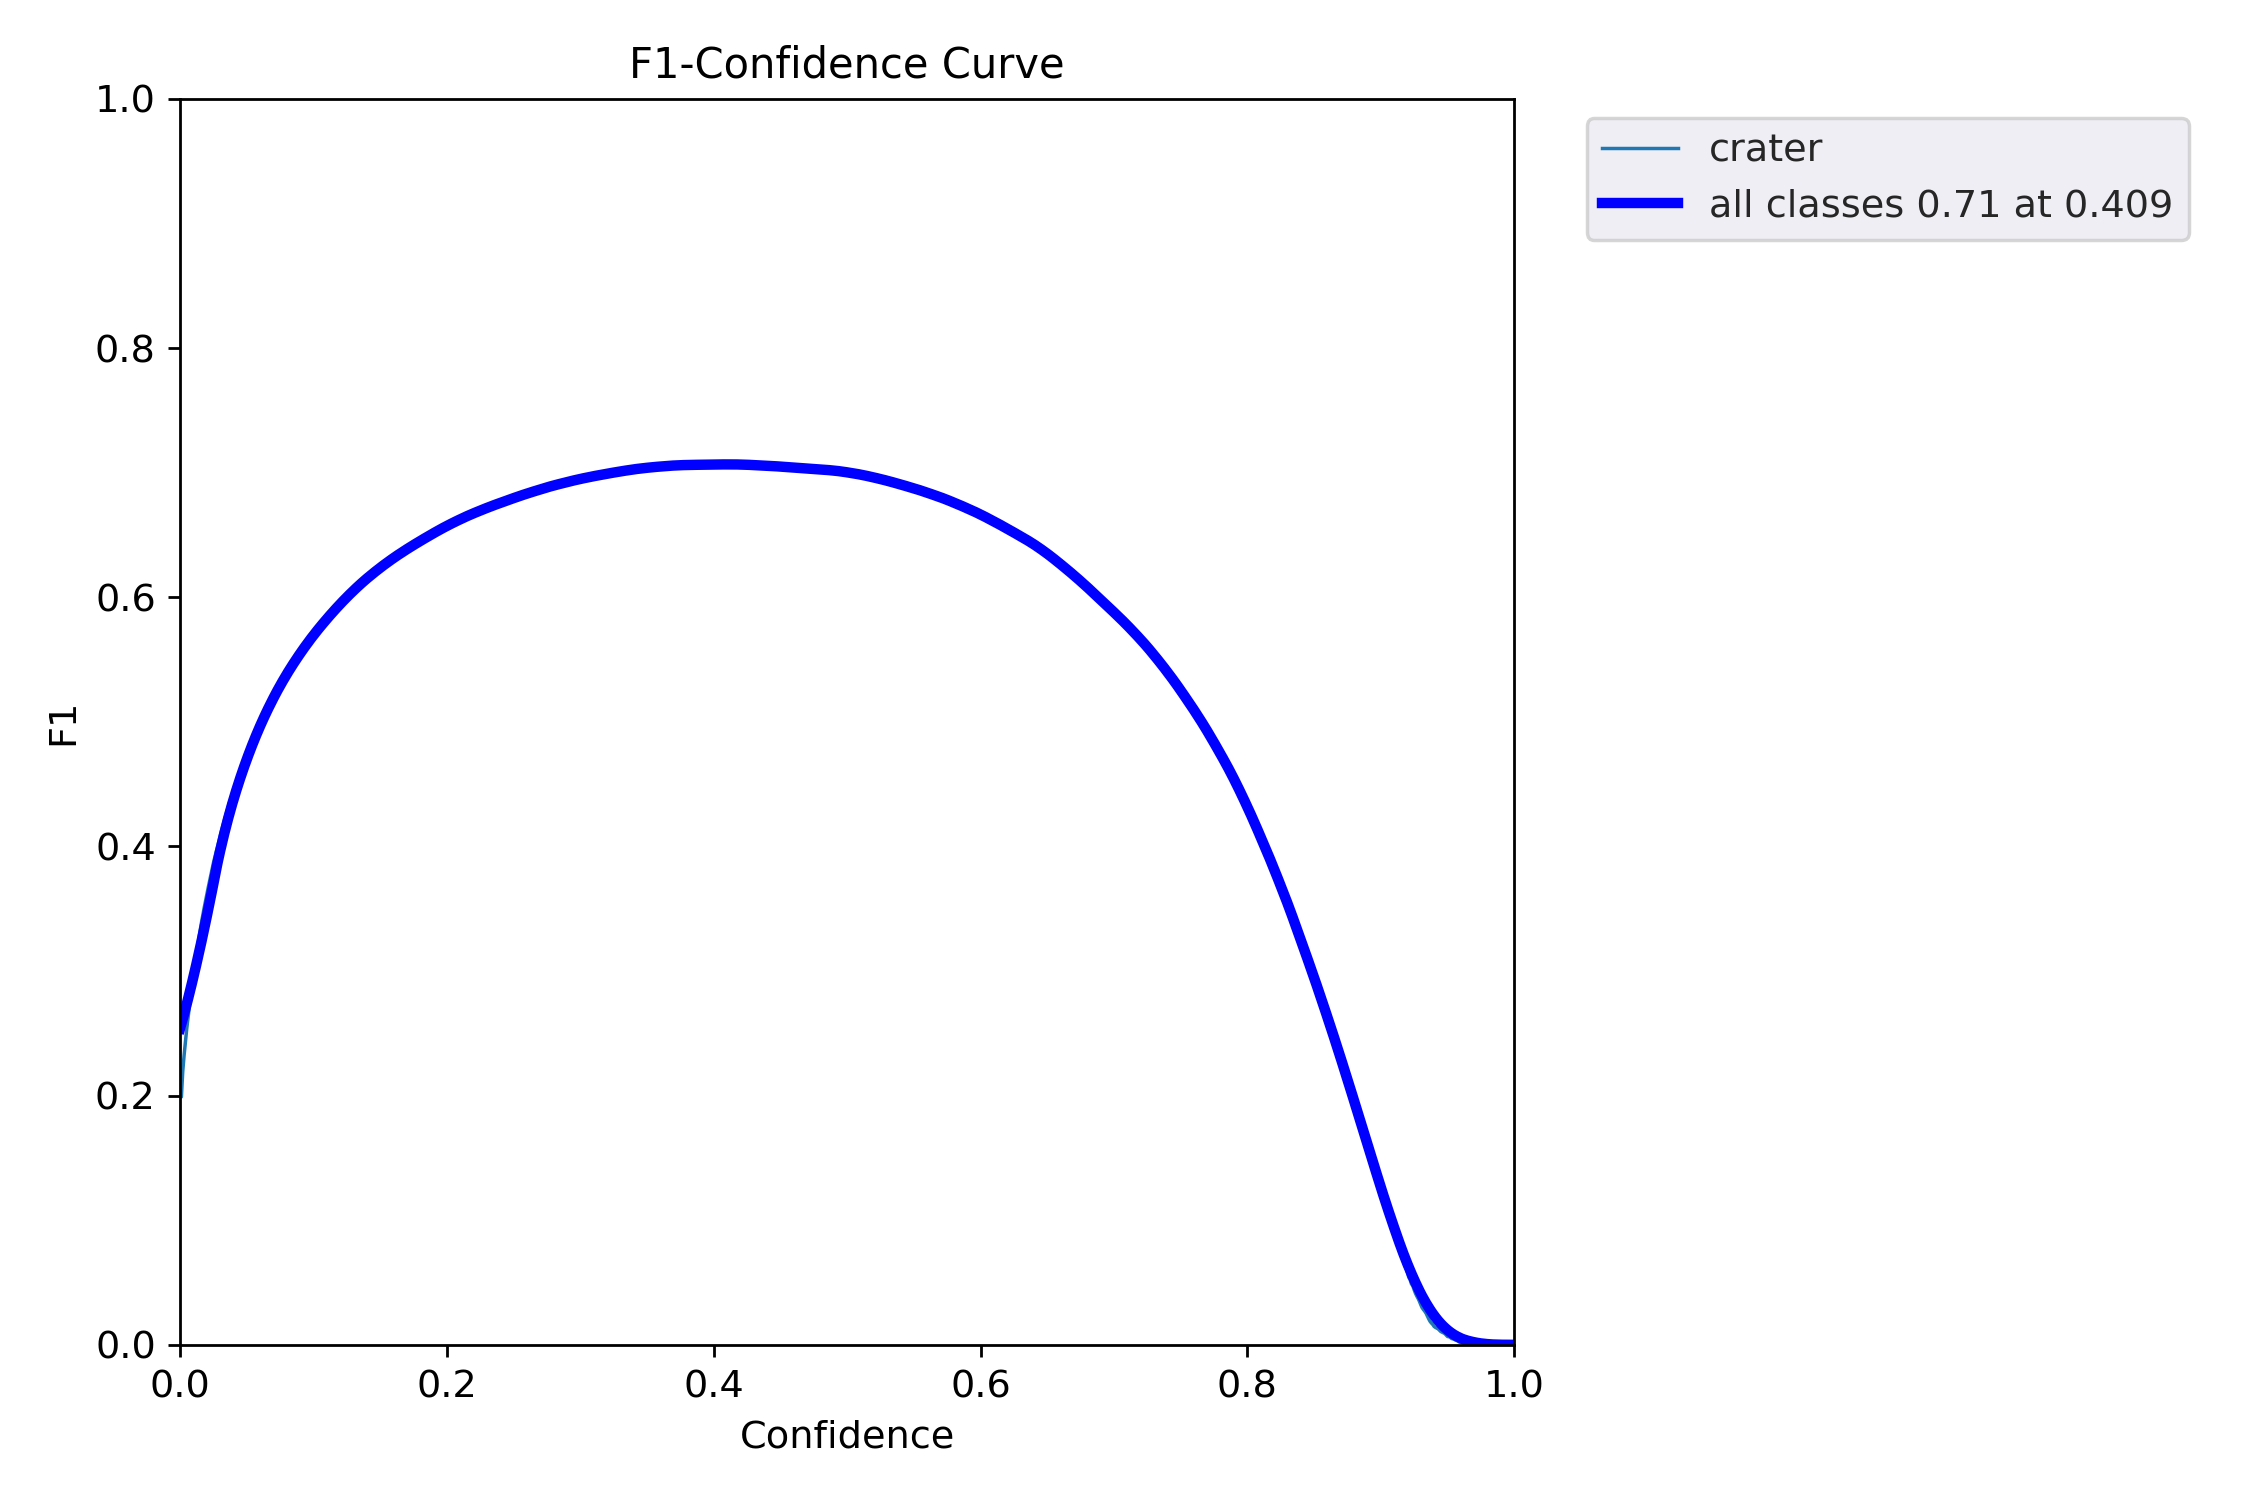

In [13]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/Lunar_Model_our_data_Ensemble_on_Right_test/F1_curve.png')


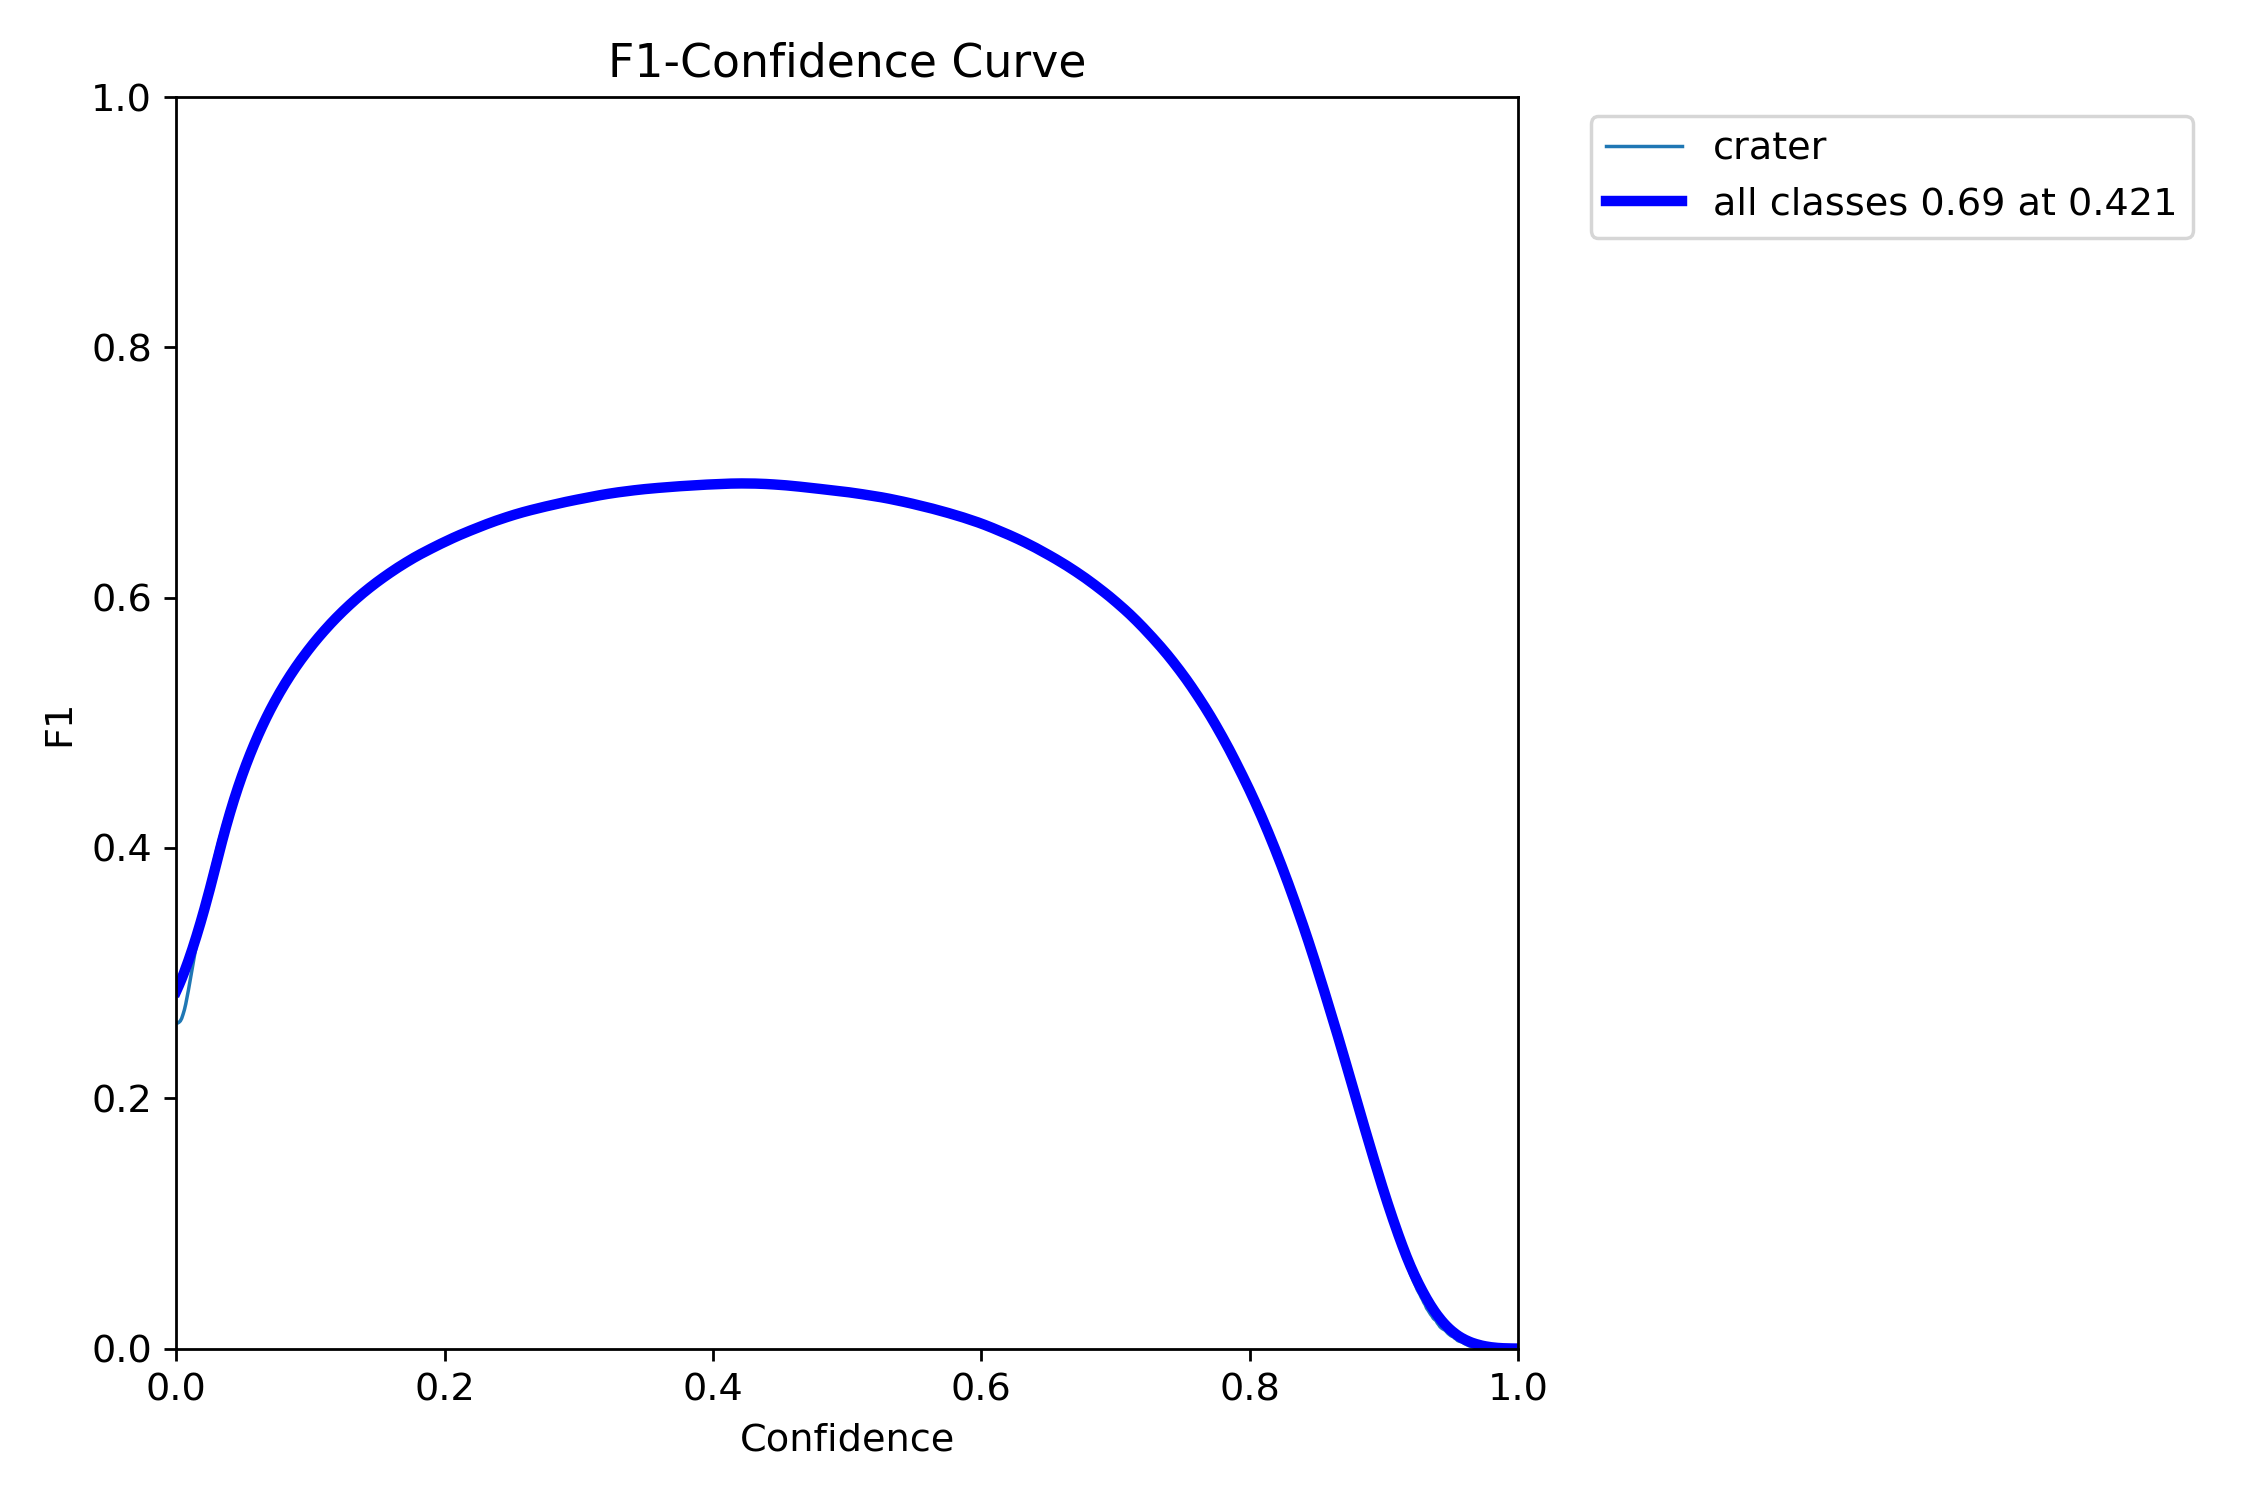

In [14]:
Image(filename='/content/drive/MyDrive/yolov5/runs/val/Lunar_Model_our_data_Ensemble_on_Left_test/F1_curve.png')

From the above plots, we can see that using the ensemble has allowed us to achieve high F1 scores, with decently high threshold values at aruond 40%.

We thought this method would be interesting to use for our models as we did not know what parts of the moon we ewre going to get for the test set on friday, and wether it would be from a darker part or lighter part of the moon. 

Of course it would have been nice to be able to compare our ensemble model with one containing our whole moon data, however we were unable to produce these datasets. 

However comparing our ensemble with the model usnig Gareth's dataset, we can say that our ensemble performed better, with 71% precision, 67% recall and 75% mAP50, compared to 73% and 44% and our mAP50 is at around 55%. 

Eventhough our precision is lower than using Gareth's data, this is fine as we probably had many false positives that were actually craters. 

# Network Design: 

The main network design changes we made was comparing the YoloV5 and YoloV8 models. We did not have enough time to look into changing loss functions or any of the architecture. 

The main differences between the architecture of V5 and V8 is: 



Yolo8 compared to Yolo5
### Difference in Loss Functions: 
- Anchor-free detections are faster and more accurate for V8. And this is the main difference in model architecture as having anchor-free detections allows for differenly shaped bounding boxes to be created and not just previously fine-tuned ones by YoloV5. 
-  The V8 backbone network which has an anchor-free detection head, and a new loss function making things much faster.

- To compare the results between V5 and V8 on the mars data: 

  - We changed the IOU to 0.5 to maximize the R and P, as well as mAP50 and therefore F1.
  - We changed the learning rate range to achieve a reasonable step size at each iteration while moving toward a minimum of the loss function.


## Moon: 

- We did not have enough time to look into implementing YoloV8 for the Moon data - as it would have required much more training time, and we were able to reach these resulst for mars friday morning. 

- However I think it could've led to good results are the eradic behaviour going on for the object-loss function for the moon data with YoloV5 is caused by the autoanchor part of the model. The model was pretrained on features (Craters) that are as small as those in our dataset, meaning the function could not really assess if what was in the bounding boxes were really creaters or not, as they were so small

- Also looking into changing the object-loss function for the moon data could've led to better results - potentially using focal loss. 

# Final Comments: 

## Final Models: 
- We decided to use our Large pretrained model for our mars crater prediction which had high precision of 88%, recall of 86% and mAP of 90%. Eventhough our V8 implementations gave higher results of 93% precision, recall 92% and mAP50 of 95%.
- We decided to use the ensemble models for the moon crater predictions. 

- We did not retrain our models with all the data from the train/val/test split once we were happy with the outcomes as it would've taken too much time. However we know this would have led to better results.

- We were able to produce a lunar dataset which had all the small craters filtered. This would have been great to implement in our lunar model to be able to detect both small and large craters efficiently. However we were not able to implement models due to time constraints and wanting to work on the GUI. 

# Extra things we would have done: 

- Maybe trying different transfer learning techniques such as freezing all the layers EXCEPT from the backbone. We think this could have led to improved results as the backbone is used to extract features from the images. Now that we think about it would've probably been great to do this. Awaiting further updates.

- Looked into manipulating the architecture of YoloV5
  - Possibly making the neck part larger (as it is primarly used to link the features processed in the backbone with the output).

- Manual Hyperparameter tuning such as different optimiser. In our case we mostly used SGD, but we could have looked into using Adam or potentially Resilient Backpropogation, which was seen to have optimal results as it is less sensitive to learning rates and converges faster than many other optimisers.